# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/CVAE_ex5/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

0         1         2         3         4         5         6     \
0     0.141376  0.126192  0.160170  0.039393  0.116594  0.244344  0.364260   
1     0.139377  0.119569  0.153211  0.039412  0.117448  0.268657  0.362977   
2     0.163800  0.184355  0.172159  0.027273  0.110422  0.169510  0.386510   
3     0.143226  0.131679  0.156749  0.038878  0.115537  0.241695  0.368068   
4     0.137737  0.123774  0.149359  0.042918  0.111843  0.259588  0.368717   
...        ...       ...       ...       ...       ...       ...       ...   
6013  0.116490  0.110039  0.161647  0.043416  0.096190  0.239978  0.371168   
6014  0.125852  0.120752  0.164564  0.039160  0.104617  0.234347  0.369856   
6015  0.107534  0.116570  0.173803  0.039604  0.088328  0.213753  0.390930   
6016  0.123527  0.140547  0.164611  0.038327  0.096956  0.192954  0.382039   
6017  0.118789  0.118466  0.158106  0.043782  0.097575  0.229872  0.372959   

          7         8         9     ...      3062      3063      3064  3065  \
0     0.179045  0.304383  0.316418  ...  0.000000  0.000000  0.000000   0.0   
1     0.172853  0.304429  0.321536  ...  0.000558  0.000000  0.000185   0.0   
2     0.206604  0.313434  0.314130  ...  0.011560  0.000000  0.000000   0.0   
3     0.185738  0.308175  0.316420  ...  0.000000  0.000457  0.000000   0.0   
4     0.180469  0.305680  0.309504  ...  0.000000  0.000000  0.000000   0.0   
...        ...       ...       ...  ...       ...       ...       ...   ...   
6013  0.168759  0.329152  0.293912  ...  0.000000  0.000000  0.000000   0.0   
6014  0.180599  0.320280  0.302117  ...  0.001283  0.000000  0.000000   0.0   
6015  0.170922  0.355653  0.284926  ...  0.000713  0.026625  0.000000   0.0   
6016  0.200973  0.332633  0.290760  ...  0.002548  0.011003  0.000000   0.0   
6017  0.169601  0.332104  0.290355  ...  0.000000  0.001279  0.000000   0.0   

          3066  3067  3068  3069      3070      3071  
0     0.011685   0.0   0.0   0.0  0.001349  0.024873  
1     0.019411   0.0   0.0   0.0  0.010698  0.031158  
2     0.038945   0.0   0.0   0.0  0.000000  0.005341  
3     0.005694   0.0   0.0   0.0  0.008102  0.020985  
4     0.018220   0.0   0.0   0.0  0.003810  0.032367  
...        ...   ...   ...   ...       ...       ...  
6013  0.002287   0.0   0.0   0.0  0.000226  0.023715  
6014  0.000000   0.0   0.0   0.0  0.001988  0.014878  
6015  0.009445   0.0   0.0   0.0  0.005314  0.000665  
6016  0.011084   0.0   0.0   0.0  0.004229  0.010059  
6017  0.011491   0.0   0.0   0.0  0.000270  0.032393  

[6018 rows x 3072 columns]

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-05-22 00:29:47,618 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-05-22 00:29:47,619 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-22 00:29:47,653 - 00_train.py - INFO - TRAINING
2021-05-22 00:29:49,532 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 12.26it/s]
2021-05-22 00:29:50,513 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.87it/s]
2021-05-22 00:29:50,676 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


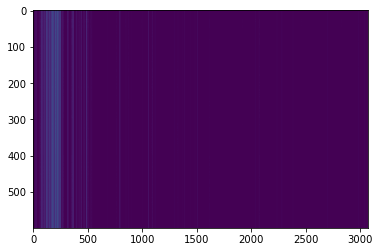

AUC      pAUC
Source_0  0.650200  0.516842
Source_1  0.546100  0.500000
Source_2  0.630800  0.498947
Target_0  0.616000  0.528421
Target_1  0.653400  0.550526
Target_2  0.608100  0.527895
mean      0.617433  0.520439
h_mean    0.615212  0.519830

2021-05-22 00:29:51,608 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1945.621562, val_AUC_hmean:0.615212, val_pAUC_hmean:0.519830, best_flag:True
2021-05-22 00:29:51,609 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.11it/s]
2021-05-22 00:29:52,024 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:29:52,187 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
2021-05-22 00:29:52,357 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1329.281687, val_AUC_hmean:0.518358, val_pAUC_hmean:0.496252, best_flag:False
2021-05-22 00:29:52,358 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.52it/s]
2021-05-22 00:29:52,767 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.17it/s]
2021-05-22 00:29:52,920 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.66it/s]


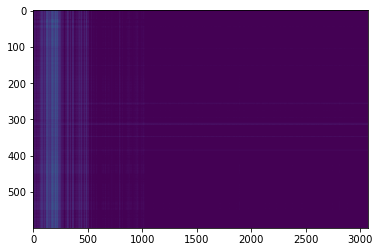

AUC      pAUC
Source_0  0.509500  0.605263
Source_1  0.391400  0.499474
Source_2  0.530500  0.539474
Target_0  0.587000  0.522632
Target_1  0.338000  0.506842
Target_2  0.540400  0.526316
mean      0.482800  0.533333
h_mean    0.464566  0.531240

2021-05-22 00:29:53,862 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1222.816182, val_AUC_hmean:0.464566, val_pAUC_hmean:0.531240, best_flag:True
2021-05-22 00:29:53,863 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.42it/s]
2021-05-22 00:29:54,287 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.33it/s]
2021-05-22 00:29:54,458 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.10it/s]
2021-05-22 00:29:54,615 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1165.597097, val_AUC_hmean:0.445350, val_pAUC_hmean:0.494975, best_flag:False
2021-05-22 00:29:54,616 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.79it/s]
2021-05-22 00:29:55,022 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.31it/s]
2021-05-22 00:29:55,194 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.03it/s]
2021-05-22 00:29:

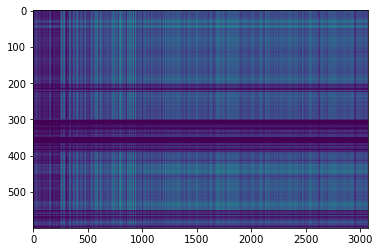

AUC      pAUC
Source_0  0.708100  0.581053
Source_1  0.754100  0.532105
Source_2  0.668200  0.626842
Target_0  0.565800  0.546842
Target_1  0.774700  0.500526
Target_2  0.636500  0.505263
mean      0.684567  0.548772
h_mean    0.676880  0.545386

2021-05-22 00:30:04,953 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:832.878164, val_AUC_hmean:0.676880, val_pAUC_hmean:0.545386, best_flag:True
2021-05-22 00:30:04,954 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.04it/s]
2021-05-22 00:30:05,343 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.59it/s]
2021-05-22 00:30:05,492 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.51it/s]
2021-05-22 00:30:05,645 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:816.763372, val_AUC_hmean:0.413416, val_pAUC_hmean:0.503102, best_flag:False
2021-05-22 00:30:05,646 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.46it/s]
2021-05-22 00:30:06,070 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.93it/s]
2021-05-22 00:30:06,224 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.00it/s]
2021-05-22 00:30:

100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
2021-05-22 00:30:17,301 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
2021-05-22 00:30:17,457 - pytorch_modeler.py - INFO - epoch:34/300, train_losses:588.661764, val_AUC_hmean:0.377460, val_pAUC_hmean:0.495648, best_flag:False
2021-05-22 00:30:17,458 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.45it/s]
2021-05-22 00:30:17,854 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.82it/s]
2021-05-22 00:30:18,012 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.13it/s]
2021-05-22 00:30:18,167 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:576.671092, val_AUC_hmean:0.355083, val_pAUC_hmean:0.484832, best_flag:False
2021-05-22 00:30:18,168 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.84it/s]
2021-05-22 00:30:18,587 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.43it/s]
2021-05-22 00:30:29,335 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.17it/s]
2021-05-22 00:30:29,487 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
2021-05-22 00:30:29,642 - pytorch_modeler.py - INFO - epoch:51/300, train_losses:434.055954, val_AUC_hmean:0.358726, val_pAUC_hmean:0.497382, best_flag:False
2021-05-22 00:30:29,643 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.25it/s]
2021-05-22 00:30:30,030 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.48it/s]
2021-05-22 00:30:30,181 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.15it/s]
2021-05-22 00:30:30,337 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:423.466998, val_AUC_hmean:0.383353, val_pAUC_hmean:0.492245, best_flag:False
2021-05-22 00:30:30,339 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:30:40,923 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.54it/s]
2021-05-22 00:30:41,318 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.14it/s]
2021-05-22 00:30:41,474 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.49it/s]
2021-05-22 00:30:41,636 - pytorch_modeler.py - INFO - epoch:68/300, train_losses:313.096710, val_AUC_hmean:0.325050, val_pAUC_hmean:0.484254, best_flag:False
2021-05-22 00:30:41,637 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.99it/s]
2021-05-22 00:30:42,039 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
2021-05-22 00:30:42,194 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:30:42,353 - pytorch_modeler.py - INFO - epoch:69/300, train_losses:307.695015, val_AUC_hmean:0.316952, val_pAUC_hmean:0.490492, best_flag:False
2021-05-22 00:30

100%|██████████| 2/2 [00:00<00:00, 15.14it/s]
2021-05-22 00:30:52,895 - pytorch_modeler.py - INFO - epoch:84/300, train_losses:233.911985, val_AUC_hmean:0.378346, val_pAUC_hmean:0.498115, best_flag:False
2021-05-22 00:30:52,896 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.65it/s]
2021-05-22 00:30:53,290 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.00it/s]
2021-05-22 00:30:53,445 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
2021-05-22 00:30:53,605 - pytorch_modeler.py - INFO - epoch:85/300, train_losses:230.741975, val_AUC_hmean:0.372050, val_pAUC_hmean:0.499444, best_flag:False
2021-05-22 00:30:53,606 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.08it/s]
2021-05-22 00:30:54,008 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:30:54,165 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
2021-05-22 00:31:04,839 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
2021-05-22 00:31:04,998 - pytorch_modeler.py - INFO - epoch:101/300, train_losses:171.694817, val_AUC_hmean:0.394618, val_pAUC_hmean:0.492976, best_flag:False
2021-05-22 00:31:04,999 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.69it/s]
2021-05-22 00:31:05,393 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.30it/s]
2021-05-22 00:31:05,544 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.17it/s]
2021-05-22 00:31:05,699 - pytorch_modeler.py - INFO - epoch:102/300, train_losses:168.799892, val_AUC_hmean:0.369377, val_pAUC_hmean:0.504580, best_flag:False
2021-05-22 00:31:05,700 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.11it/s]
2021-05-22 00:31:06,088 - pytorch_modeler.py - INFO - valid_source
100%|█████████

2021-05-22 00:31:16,507 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.68it/s]
2021-05-22 00:31:16,889 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:31:17,053 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
2021-05-22 00:31:17,213 - pytorch_modeler.py - INFO - epoch:118/300, train_losses:130.352701, val_AUC_hmean:0.348389, val_pAUC_hmean:0.498944, best_flag:False
2021-05-22 00:31:17,214 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.41it/s]
2021-05-22 00:31:17,624 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.92it/s]
2021-05-22 00:31:17,777 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.73it/s]
2021-05-22 00:31:17,937 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:128.897594, val_AUC_hmean:0.351022, val_pAUC_hmean:0.501233, best_flag:False
2021-05-22 00:

100%|██████████| 2/2 [00:00<00:00, 15.59it/s]
2021-05-22 00:31:28,870 - pytorch_modeler.py - INFO - epoch:134/300, train_losses:95.056525, val_AUC_hmean:0.367632, val_pAUC_hmean:0.497607, best_flag:False
2021-05-22 00:31:28,871 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.71it/s]
2021-05-22 00:31:29,252 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.35it/s]
2021-05-22 00:31:29,403 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.54it/s]
2021-05-22 00:31:29,553 - pytorch_modeler.py - INFO - epoch:135/300, train_losses:93.798403, val_AUC_hmean:0.340765, val_pAUC_hmean:0.501003, best_flag:False
2021-05-22 00:31:29,554 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.53it/s]
2021-05-22 00:31:29,937 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.42it/s]
2021-05-22 00:31:30,087 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 15.12it/s]
2021-05-22 00:31:40,468 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.17it/s]
2021-05-22 00:31:40,621 - pytorch_modeler.py - INFO - epoch:151/300, train_losses:69.233604, val_AUC_hmean:0.366103, val_pAUC_hmean:0.494942, best_flag:False
2021-05-22 00:31:40,622 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.93it/s]
2021-05-22 00:31:41,000 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
2021-05-22 00:31:41,150 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.00it/s]
2021-05-22 00:31:41,305 - pytorch_modeler.py - INFO - epoch:152/300, train_losses:68.015260, val_AUC_hmean:0.378268, val_pAUC_hmean:0.489336, best_flag:False
2021-05-22 00:31:41,306 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.36it/s]
2021-05-22 00:31:41,691 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.37it/s]
2021-05-22 00:31:52,052 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.40it/s]
2021-05-22 00:31:52,203 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
2021-05-22 00:31:52,362 - pytorch_modeler.py - INFO - epoch:168/300, train_losses:49.730917, val_AUC_hmean:0.390380, val_pAUC_hmean:0.492046, best_flag:False
2021-05-22 00:31:52,363 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.98it/s]
2021-05-22 00:31:52,752 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.45it/s]
2021-05-22 00:31:52,900 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.70it/s]
2021-05-22 00:31:53,049 - pytorch_modeler.py - INFO - epoch:169/300, train_losses:49.286831, val_AUC_hmean:0.380013, val_pAUC_hmean:0.499095, best_flag:False
2021-05-22 00:31:53,050 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:32:03,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.76it/s]
2021-05-22 00:32:03,830 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.57it/s]
2021-05-22 00:32:03,979 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.53it/s]
2021-05-22 00:32:04,130 - pytorch_modeler.py - INFO - epoch:185/300, train_losses:36.173179, val_AUC_hmean:0.368253, val_pAUC_hmean:0.492763, best_flag:False
2021-05-22 00:32:04,131 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.71it/s]
2021-05-22 00:32:04,524 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.16it/s]
2021-05-22 00:32:04,676 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.55it/s]
2021-05-22 00:32:04,827 - pytorch_modeler.py - INFO - epoch:186/300, train_losses:35.523746, val_AUC_hmean:0.389787, val_pAUC_hmean:0.514430, best_flag:False
2021-05-22 00:32

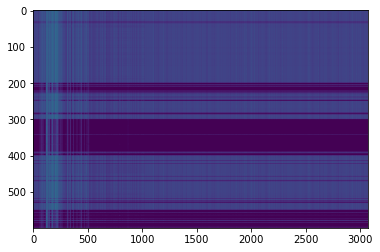

AUC      pAUC
Source_0  0.499800  0.526316
Source_1  0.598700  0.627368
Source_2  0.560400  0.524211
Target_0  0.467700  0.504211
Target_1  0.841800  0.790526
Target_2  0.791200  0.595263
mean      0.626600  0.594649
h_mean    0.597283  0.580844

2021-05-22 00:32:06,246 - pytorch_modeler.py - INFO - epoch:187/300, train_losses:35.154364, val_AUC_hmean:0.597283, val_pAUC_hmean:0.580844, best_flag:True
2021-05-22 00:32:06,247 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.43it/s]
2021-05-22 00:32:06,631 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.73it/s]
2021-05-22 00:32:06,778 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:32:06,936 - pytorch_modeler.py - INFO - epoch:188/300, train_losses:34.189950, val_AUC_hmean:0.387843, val_pAUC_hmean:0.502186, best_flag:False
2021-05-22 00:32:06,938 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.65it/s]
2021-05-22 00:32:07,319 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.34it/s]
2021-05-22 00:32:07,472 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.09it/s]
2021-05-22 00:32:

100%|██████████| 2/2 [00:00<00:00, 15.53it/s]
2021-05-22 00:32:17,837 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.71it/s]
2021-05-22 00:32:17,985 - pytorch_modeler.py - INFO - epoch:204/300, train_losses:25.138936, val_AUC_hmean:0.390666, val_pAUC_hmean:0.497782, best_flag:False
2021-05-22 00:32:17,986 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.26it/s]
2021-05-22 00:32:18,372 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
2021-05-22 00:32:18,534 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.71it/s]
2021-05-22 00:32:18,683 - pytorch_modeler.py - INFO - epoch:205/300, train_losses:24.447221, val_AUC_hmean:0.390078, val_pAUC_hmean:0.497040, best_flag:False
2021-05-22 00:32:18,684 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.91it/s]
2021-05-22 00:32:19,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.52it/s]
2021-05-22 00:32:29,584 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:32:29,740 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
2021-05-22 00:32:29,897 - pytorch_modeler.py - INFO - epoch:221/300, train_losses:21.359696, val_AUC_hmean:0.391132, val_pAUC_hmean:0.496881, best_flag:False
2021-05-22 00:32:29,898 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.95it/s]
2021-05-22 00:32:30,288 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.43it/s]
2021-05-22 00:32:30,438 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.38it/s]
2021-05-22 00:32:30,592 - pytorch_modeler.py - INFO - epoch:222/300, train_losses:20.080964, val_AUC_hmean:0.347739, val_pAUC_hmean:0.500403, best_flag:False
2021-05-22 00:32:30,593 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:32:40,961 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.39it/s]
2021-05-22 00:32:41,358 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.28it/s]
2021-05-22 00:32:41,509 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
2021-05-22 00:32:41,664 - pytorch_modeler.py - INFO - epoch:238/300, train_losses:14.333901, val_AUC_hmean:0.391657, val_pAUC_hmean:0.487907, best_flag:False
2021-05-22 00:32:41,666 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.39it/s]
2021-05-22 00:32:42,050 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.11it/s]
2021-05-22 00:32:42,204 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.73it/s]
2021-05-22 00:32:42,355 - pytorch_modeler.py - INFO - epoch:239/300, train_losses:14.587025, val_AUC_hmean:0.337239, val_pAUC_hmean:0.502775, best_flag:False
2021-05-22 00:32

100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
2021-05-22 00:32:52,753 - pytorch_modeler.py - INFO - epoch:254/300, train_losses:10.398921, val_AUC_hmean:0.355696, val_pAUC_hmean:0.499393, best_flag:False
2021-05-22 00:32:52,754 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.77it/s]
2021-05-22 00:32:53,133 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.87it/s]
2021-05-22 00:32:53,290 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.05it/s]
2021-05-22 00:32:53,445 - pytorch_modeler.py - INFO - epoch:255/300, train_losses:9.809999, val_AUC_hmean:0.366165, val_pAUC_hmean:0.496585, best_flag:False
2021-05-22 00:32:53,446 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.57it/s]
2021-05-22 00:32:53,828 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.08it/s]
2021-05-22 00:32:53,982 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 

100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
2021-05-22 00:33:04,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
2021-05-22 00:33:04,616 - pytorch_modeler.py - INFO - epoch:271/300, train_losses:7.237399, val_AUC_hmean:0.366283, val_pAUC_hmean:0.496939, best_flag:False
2021-05-22 00:33:04,617 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.94it/s]
2021-05-22 00:33:05,008 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.55it/s]
2021-05-22 00:33:05,165 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.33it/s]
2021-05-22 00:33:05,318 - pytorch_modeler.py - INFO - epoch:272/300, train_losses:7.234633, val_AUC_hmean:0.352956, val_pAUC_hmean:0.496509, best_flag:False
2021-05-22 00:33:05,319 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.29it/s]
2021-05-22 00:33:05,705 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

100%|██████████| 12/12 [00:00<00:00, 31.53it/s]
2021-05-22 00:33:16,124 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.51it/s]
2021-05-22 00:33:16,275 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
2021-05-22 00:33:16,432 - pytorch_modeler.py - INFO - epoch:288/300, train_losses:5.589044, val_AUC_hmean:0.368423, val_pAUC_hmean:0.497110, best_flag:False
2021-05-22 00:33:16,434 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.83it/s]
2021-05-22 00:33:16,826 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.80it/s]
2021-05-22 00:33:16,972 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:33:17,133 - pytorch_modeler.py - INFO - epoch:289/300, train_losses:5.497584, val_AUC_hmean:0.370557, val_pAUC_hmean:0.493820, best_flag:False
2021-05-22 00:33:17,134 - pytorch_modeler.py - INFO - train
100%|██████████| 1

AUC      pAUC
Source_0  0.499800  0.526316
Source_1  0.598700  0.627368
Source_2  0.560400  0.524211
Target_0  0.467700  0.504211
Target_1  0.841800  0.790526
Target_2  0.791200  0.595263
mean      0.626600  0.594649
h_mean    0.597283  0.580844

2021-05-22 00:33:24,759 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-05-22 00:33:24,760 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-22 00:33:24,790 - 00_train.py - INFO - TRAINING


elapsed time: 217.140635014 [sec]


2021-05-22 00:33:24,988 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 31.37it/s]
2021-05-22 00:33:25,372 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.73it/s]
2021-05-22 00:33:25,529 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


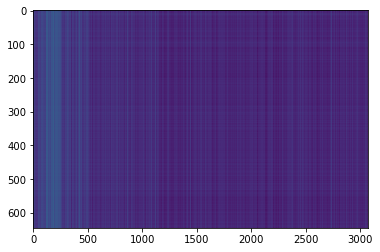

AUC      pAUC
Source_0  0.566740  0.547201
Source_1  0.521176  0.539022
Source_2  0.596417  0.531881
Target_0  0.702353  0.605568
Target_1  0.629115  0.535052
Target_2  0.604683  0.540936
mean      0.603414  0.549943
h_mean    0.598386  0.548858

2021-05-22 00:33:26,425 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2203.049917, val_AUC_hmean:0.598386, val_pAUC_hmean:0.548858, best_flag:True
2021-05-22 00:33:26,426 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.00it/s]
2021-05-22 00:33:26,815 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.91it/s]
2021-05-22 00:33:26,970 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:33:27,127 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1635.165558, val_AUC_hmean:0.458586, val_pAUC_hmean:0.519108, best_flag:False
2021-05-22 00:33:27,128 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.79it/s]
2021-05-22 00:33:27,520 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:33:27,677 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
2021-05-22 00:33:

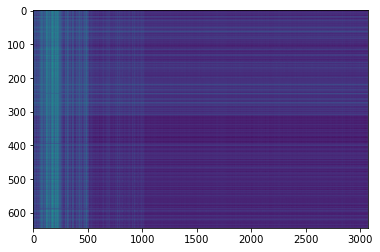

AUC      pAUC
Source_0  0.438388  0.486794
Source_1  0.882888  0.698939
Source_2  0.620840  0.548761
Target_0  0.503665  0.520488
Target_1  0.852366  0.637120
Target_2  0.571587  0.502297
mean      0.644956  0.565733
h_mean    0.604070  0.556123

2021-05-22 00:33:29,324 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1340.188914, val_AUC_hmean:0.604070, val_pAUC_hmean:0.556123, best_flag:True
2021-05-22 00:33:29,325 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.93it/s]
2021-05-22 00:33:29,715 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
2021-05-22 00:33:29,876 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.14it/s]


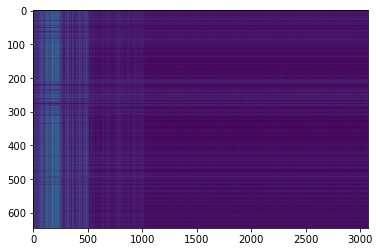

AUC      pAUC
Source_0  0.638926  0.582032
Source_1  0.901835  0.793517
Source_2  0.624866  0.576235
Target_0  0.818576  0.662626
Target_1  0.855195  0.748033
Target_2  0.636190  0.594403
mean      0.745931  0.659474
h_mean    0.728409  0.649204

2021-05-22 00:33:30,775 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:1271.252838, val_AUC_hmean:0.728409, val_pAUC_hmean:0.649204, best_flag:True
2021-05-22 00:33:30,776 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.90it/s]
2021-05-22 00:33:31,179 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.81it/s]
2021-05-22 00:33:31,335 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.18it/s]
2021-05-22 00:33:31,489 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1216.138702, val_AUC_hmean:0.427740, val_pAUC_hmean:0.519132, best_flag:False
2021-05-22 00:33:31,490 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.73it/s]
2021-05-22 00:33:31,883 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
2021-05-22 00:33:32,038 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.11it/s]


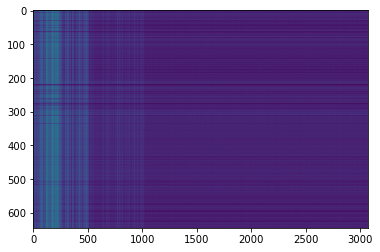

AUC      pAUC
Source_0  0.607570  0.603110
Source_1  0.730110  0.725561
Source_2  0.674785  0.600955
Target_0  0.812789  0.699074
Target_1  0.734997  0.726103
Target_2  0.693492  0.589390
mean      0.708957  0.657366
h_mean    0.703369  0.651842

2021-05-22 00:33:32,930 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1168.418844, val_AUC_hmean:0.703369, val_pAUC_hmean:0.651842, best_flag:True
2021-05-22 00:33:32,931 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.94it/s]
2021-05-22 00:33:33,321 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
2021-05-22 00:33:33,478 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.83it/s]
2021-05-22 00:33:33,645 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:1124.454468, val_AUC_hmean:0.621008, val_pAUC_hmean:0.647766, best_flag:False
2021-05-22 00:33:33,646 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.33it/s]
2021-05-22 00:33:34,032 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.26it/s]
2021-05-22 00:33:34,193 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:33:

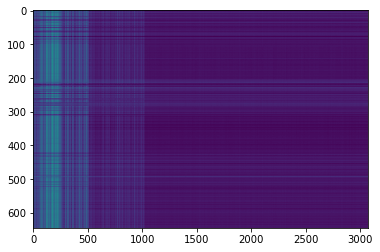

AUC      pAUC
Source_0  0.765714  0.574192
Source_1  0.916495  0.763916
Source_2  0.694713  0.609501
Target_0  0.893904  0.764762
Target_1  0.926012  0.816890
Target_2  0.627143  0.637845
mean      0.803997  0.694518
h_mean    0.786406  0.682529

2021-05-22 00:33:36,524 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:1023.618744, val_AUC_hmean:0.786406, val_pAUC_hmean:0.682529, best_flag:True
2021-05-22 00:33:36,525 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.56it/s]
2021-05-22 00:33:36,920 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:33:37,076 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:33:37,235 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:993.639460, val_AUC_hmean:0.767731, val_pAUC_hmean:0.669295, best_flag:False
2021-05-22 00:33:37,236 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.71it/s]
2021-05-22 00:33:37,629 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:33:37,789 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.94it/s]


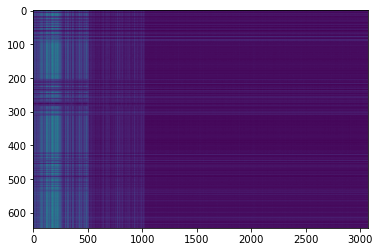

AUC      pAUC
Source_0  0.688791  0.594885
Source_1  0.935957  0.850462
Source_2  0.668612  0.643543
Target_0  0.860629  0.778671
Target_1  0.926012  0.870948
Target_2  0.648175  0.587093
mean      0.788029  0.720934
h_mean    0.769180  0.702046

2021-05-22 00:33:38,690 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:975.883911, val_AUC_hmean:0.769180, val_pAUC_hmean:0.702046, best_flag:True
2021-05-22 00:33:38,691 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.44it/s]
2021-05-22 00:33:39,147 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
2021-05-22 00:33:39,307 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:33:39,466 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:946.538213, val_AUC_hmean:0.701821, val_pAUC_hmean:0.575296, best_flag:False
2021-05-22 00:33:39,467 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.91it/s]
2021-05-22 00:33:39,932 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.40it/s]
2021-05-22 00:33:40,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
2021-05-22 00:33:

100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:33:51,913 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:33:52,072 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:658.634898, val_AUC_hmean:0.732104, val_pAUC_hmean:0.643050, best_flag:False
2021-05-22 00:33:52,073 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.55it/s]
2021-05-22 00:33:52,527 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
2021-05-22 00:33:52,681 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
2021-05-22 00:33:52,839 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:644.799179, val_AUC_hmean:0.715582, val_pAUC_hmean:0.613787, best_flag:False
2021-05-22 00:33:52,840 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.42it/s]
2021-05-22 00:33:53,296 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.11it/s]
2021-05-22 00:34:05,083 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:34:05,241 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
2021-05-22 00:34:05,399 - pytorch_modeler.py - INFO - epoch:47/300, train_losses:471.023577, val_AUC_hmean:0.734197, val_pAUC_hmean:0.621563, best_flag:False
2021-05-22 00:34:05,400 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.81it/s]
2021-05-22 00:34:05,886 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.66it/s]
2021-05-22 00:34:06,053 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
2021-05-22 00:34:06,213 - pytorch_modeler.py - INFO - epoch:48/300, train_losses:463.628975, val_AUC_hmean:0.722091, val_pAUC_hmean:0.615204, best_flag:False
2021-05-22 00:34:06,214 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:34:18,420 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.11it/s]
2021-05-22 00:34:18,942 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
2021-05-22 00:34:19,099 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
2021-05-22 00:34:19,256 - pytorch_modeler.py - INFO - epoch:64/300, train_losses:346.080391, val_AUC_hmean:0.552255, val_pAUC_hmean:0.567121, best_flag:False
2021-05-22 00:34:19,257 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.13it/s]
2021-05-22 00:34:19,779 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:34:19,938 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
2021-05-22 00:34:20,096 - pytorch_modeler.py - INFO - epoch:65/300, train_losses:340.961001, val_AUC_hmean:0.353264, val_pAUC_hmean:0.519694, best_flag:False
2021-05-22 00:34

100%|██████████| 2/2 [00:00<00:00,  7.70it/s]
2021-05-22 00:34:33,740 - pytorch_modeler.py - INFO - epoch:80/300, train_losses:263.503642, val_AUC_hmean:0.695670, val_pAUC_hmean:0.577612, best_flag:False
2021-05-22 00:34:33,741 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.66it/s]
2021-05-22 00:34:34,250 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  7.73it/s]
2021-05-22 00:34:34,528 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  7.71it/s]
2021-05-22 00:34:34,810 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:258.669862, val_AUC_hmean:0.704810, val_pAUC_hmean:0.602246, best_flag:False
2021-05-22 00:34:34,811 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.64it/s]
2021-05-22 00:34:35,321 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  7.92it/s]
2021-05-22 00:34:35,594 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 13.84it/s]
2021-05-22 00:34:51,428 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.36it/s]
2021-05-22 00:34:51,580 - pytorch_modeler.py - INFO - epoch:97/300, train_losses:200.569809, val_AUC_hmean:0.717645, val_pAUC_hmean:0.590469, best_flag:False
2021-05-22 00:34:51,581 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.55it/s]
2021-05-22 00:34:51,976 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.21it/s]
2021-05-22 00:34:52,126 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.78it/s]
2021-05-22 00:34:52,274 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:199.584967, val_AUC_hmean:0.701677, val_pAUC_hmean:0.572010, best_flag:False
2021-05-22 00:34:52,275 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.50it/s]
2021-05-22 00:34:52,658 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

2021-05-22 00:35:02,877 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.07it/s]
2021-05-22 00:35:03,265 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.05it/s]
2021-05-22 00:35:03,418 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.86it/s]
2021-05-22 00:35:03,574 - pytorch_modeler.py - INFO - epoch:114/300, train_losses:144.447191, val_AUC_hmean:0.698102, val_pAUC_hmean:0.583601, best_flag:False
2021-05-22 00:35:03,575 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.61it/s]
2021-05-22 00:35:03,969 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
2021-05-22 00:35:04,124 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.60it/s]
2021-05-22 00:35:04,293 - pytorch_modeler.py - INFO - epoch:115/300, train_losses:140.789795, val_AUC_hmean:0.704666, val_pAUC_hmean:0.590838, best_flag:False
2021-05-22 00:

100%|██████████| 2/2 [00:00<00:00, 14.97it/s]
2021-05-22 00:35:14,890 - pytorch_modeler.py - INFO - epoch:130/300, train_losses:106.198065, val_AUC_hmean:0.682334, val_pAUC_hmean:0.576520, best_flag:False
2021-05-22 00:35:14,892 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.02it/s]
2021-05-22 00:35:15,281 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.48it/s]
2021-05-22 00:35:15,450 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
2021-05-22 00:35:15,609 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:104.058240, val_AUC_hmean:0.675822, val_pAUC_hmean:0.578348, best_flag:False
2021-05-22 00:35:15,610 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.93it/s]
2021-05-22 00:35:16,000 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:35:16,156 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
2021-05-22 00:35:27,376 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:35:27,534 - pytorch_modeler.py - INFO - epoch:147/300, train_losses:76.564126, val_AUC_hmean:0.693966, val_pAUC_hmean:0.584551, best_flag:False
2021-05-22 00:35:27,535 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.52it/s]
2021-05-22 00:35:27,930 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.88it/s]
2021-05-22 00:35:28,107 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
2021-05-22 00:35:28,266 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:75.493483, val_AUC_hmean:0.698678, val_pAUC_hmean:0.593205, best_flag:False
2021-05-22 00:35:28,267 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.76it/s]
2021-05-22 00:35:28,673 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 27.30it/s]
2021-05-22 00:35:39,830 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.70it/s]
2021-05-22 00:35:40,009 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
2021-05-22 00:35:40,176 - pytorch_modeler.py - INFO - epoch:164/300, train_losses:56.446885, val_AUC_hmean:0.684560, val_pAUC_hmean:0.564218, best_flag:False
2021-05-22 00:35:40,177 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.64it/s]
2021-05-22 00:35:40,584 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.00it/s]
2021-05-22 00:35:40,763 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.02it/s]
2021-05-22 00:35:40,928 - pytorch_modeler.py - INFO - epoch:165/300, train_losses:55.046169, val_AUC_hmean:0.700443, val_pAUC_hmean:0.577610, best_flag:False
2021-05-22 00:35:40,929 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:35:51,955 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.52it/s]
2021-05-22 00:35:52,364 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:35:52,525 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
2021-05-22 00:35:52,687 - pytorch_modeler.py - INFO - epoch:181/300, train_losses:40.633610, val_AUC_hmean:0.693021, val_pAUC_hmean:0.587770, best_flag:False
2021-05-22 00:35:52,689 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.04it/s]
2021-05-22 00:35:53,090 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:35:53,250 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
2021-05-22 00:35:53,411 - pytorch_modeler.py - INFO - epoch:182/300, train_losses:40.410100, val_AUC_hmean:0.704432, val_pAUC_hmean:0.589473, best_flag:False
2021-05-22 00:35

100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
2021-05-22 00:36:04,543 - pytorch_modeler.py - INFO - epoch:197/300, train_losses:32.547320, val_AUC_hmean:0.766962, val_pAUC_hmean:0.645974, best_flag:False
2021-05-22 00:36:04,544 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.14it/s]
2021-05-22 00:36:04,945 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
2021-05-22 00:36:05,108 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
2021-05-22 00:36:05,269 - pytorch_modeler.py - INFO - epoch:198/300, train_losses:34.078835, val_AUC_hmean:0.718948, val_pAUC_hmean:0.602532, best_flag:False
2021-05-22 00:36:05,270 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.21it/s]
2021-05-22 00:36:05,669 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
2021-05-22 00:36:05,826 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
2021-05-22 00:36:16,559 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.11it/s]
2021-05-22 00:36:16,714 - pytorch_modeler.py - INFO - epoch:214/300, train_losses:25.514580, val_AUC_hmean:0.649330, val_pAUC_hmean:0.571252, best_flag:False
2021-05-22 00:36:16,716 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.74it/s]
2021-05-22 00:36:17,121 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
2021-05-22 00:36:17,278 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.86it/s]
2021-05-22 00:36:17,435 - pytorch_modeler.py - INFO - epoch:215/300, train_losses:23.287368, val_AUC_hmean:0.666937, val_pAUC_hmean:0.579419, best_flag:False
2021-05-22 00:36:17,437 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.35it/s]
2021-05-22 00:36:17,834 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 29.91it/s]
2021-05-22 00:36:28,640 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
2021-05-22 00:36:28,801 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
2021-05-22 00:36:28,966 - pytorch_modeler.py - INFO - epoch:231/300, train_losses:15.563965, val_AUC_hmean:0.698652, val_pAUC_hmean:0.593775, best_flag:False
2021-05-22 00:36:28,967 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.44it/s]
2021-05-22 00:36:29,364 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
2021-05-22 00:36:29,522 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.09it/s]
2021-05-22 00:36:29,679 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:15.386293, val_AUC_hmean:0.712544, val_pAUC_hmean:0.604882, best_flag:False
2021-05-22 00:36:29,680 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:36:40,453 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.91it/s]
2021-05-22 00:36:40,844 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.82it/s]
2021-05-22 00:36:41,001 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:36:41,161 - pytorch_modeler.py - INFO - epoch:248/300, train_losses:11.754922, val_AUC_hmean:0.693986, val_pAUC_hmean:0.609926, best_flag:False
2021-05-22 00:36:41,162 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.16it/s]
2021-05-22 00:36:41,562 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.88it/s]
2021-05-22 00:36:41,728 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
2021-05-22 00:36:41,888 - pytorch_modeler.py - INFO - epoch:249/300, train_losses:10.937042, val_AUC_hmean:0.697762, val_pAUC_hmean:0.606821, best_flag:False
2021-05-22 00:36

100%|██████████| 2/2 [00:00<00:00, 15.08it/s]
2021-05-22 00:36:52,683 - pytorch_modeler.py - INFO - epoch:264/300, train_losses:8.202053, val_AUC_hmean:0.695004, val_pAUC_hmean:0.589949, best_flag:False
2021-05-22 00:36:52,684 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.18it/s]
2021-05-22 00:36:53,084 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.49it/s]
2021-05-22 00:36:53,244 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.00it/s]
2021-05-22 00:36:53,400 - pytorch_modeler.py - INFO - epoch:265/300, train_losses:8.453987, val_AUC_hmean:0.696018, val_pAUC_hmean:0.592287, best_flag:False
2021-05-22 00:36:53,401 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.45it/s]
2021-05-22 00:36:53,798 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:36:53,955 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2

100%|██████████| 2/2 [00:00<00:00, 13.54it/s]
2021-05-22 00:37:04,843 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:37:05,005 - pytorch_modeler.py - INFO - epoch:281/300, train_losses:5.863950, val_AUC_hmean:0.692649, val_pAUC_hmean:0.590571, best_flag:False
2021-05-22 00:37:05,006 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.45it/s]
2021-05-22 00:37:05,402 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
2021-05-22 00:37:05,565 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.48it/s]
2021-05-22 00:37:05,736 - pytorch_modeler.py - INFO - epoch:282/300, train_losses:6.174308, val_AUC_hmean:0.692932, val_pAUC_hmean:0.584820, best_flag:False
2021-05-22 00:37:05,737 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.16it/s]
2021-05-22 00:37:06,125 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

100%|██████████| 12/12 [00:00<00:00, 31.10it/s]
2021-05-22 00:37:16,908 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:37:17,067 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:37:17,226 - pytorch_modeler.py - INFO - epoch:298/300, train_losses:4.710479, val_AUC_hmean:0.694083, val_pAUC_hmean:0.584549, best_flag:False
2021-05-22 00:37:17,227 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.12it/s]
2021-05-22 00:37:17,628 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:37:17,785 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
2021-05-22 00:37:17,941 - pytorch_modeler.py - INFO - epoch:299/300, train_losses:4.691147, val_AUC_hmean:0.691558, val_pAUC_hmean:0.579142, best_flag:False
2021-05-22 00:37:17,942 - pytorch_modeler.py - INFO - train
100%|██████████| 1

AUC      pAUC
Source_0  0.688791  0.594885
Source_1  0.935957  0.850462
Source_2  0.668612  0.643543
Target_0  0.860629  0.778671
Target_1  0.926012  0.870948
Target_2  0.648175  0.587093
mean      0.788029  0.720934
h_mean    0.769180  0.702046

2021-05-22 00:37:18,660 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-05-22 00:37:18,661 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-22 00:37:18,693 - 00_train.py - INFO - TRAINING


elapsed time: 233.900465727 [sec]


2021-05-22 00:37:18,887 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 29.78it/s]
2021-05-22 00:37:19,293 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
2021-05-22 00:37:19,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.86it/s]


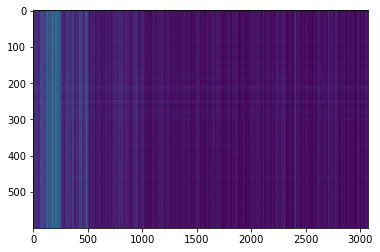

AUC      pAUC
Source_0  0.439900  0.513158
Source_1  0.529200  0.530526
Source_2  0.457500  0.482105
Target_0  0.509000  0.486316
Target_1  0.716800  0.591579
Target_2  0.442300  0.483158
mean      0.515783  0.514474
h_mean    0.501282  0.511759

2021-05-22 00:37:20,328 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1971.100555, val_AUC_hmean:0.501282, val_pAUC_hmean:0.511759, best_flag:True
2021-05-22 00:37:20,329 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.99it/s]
2021-05-22 00:37:20,718 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.93it/s]
2021-05-22 00:37:20,883 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


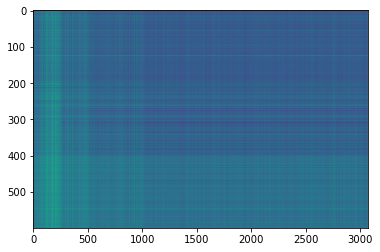

AUC      pAUC
Source_0  0.554000  0.546316
Source_1  0.604800  0.505789
Source_2  0.407900  0.514211
Target_0  0.492000  0.536316
Target_1  0.571500  0.500000
Target_2  0.556100  0.533158
mean      0.531050  0.522632
h_mean    0.522165  0.522081

2021-05-22 00:37:21,779 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1249.665436, val_AUC_hmean:0.522165, val_pAUC_hmean:0.522081, best_flag:True
2021-05-22 00:37:21,780 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.66it/s]
2021-05-22 00:37:22,173 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
2021-05-22 00:37:22,329 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.85it/s]
2021-05-22 00:37:22,488 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1100.049601, val_AUC_hmean:0.531147, val_pAUC_hmean:0.511720, best_flag:False
2021-05-22 00:37:22,489 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.37it/s]
2021-05-22 00:37:22,887 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.95it/s]
2021-05-22 00:37:23,041 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]


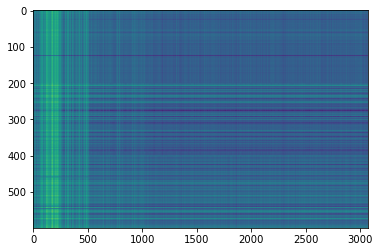

AUC      pAUC
Source_0  0.561800  0.559474
Source_1  0.569900  0.519474
Source_2  0.382400  0.503684
Target_0  0.629600  0.559474
Target_1  0.589000  0.556842
Target_2  0.423000  0.474737
mean      0.525950  0.528947
h_mean    0.508478  0.526896

2021-05-22 00:37:23,948 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1040.257528, val_AUC_hmean:0.508478, val_pAUC_hmean:0.526896, best_flag:True
2021-05-22 00:37:23,949 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.13it/s]
2021-05-22 00:37:24,349 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
2021-05-22 00:37:24,507 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
2021-05-22 00:37:24,662 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:987.450485, val_AUC_hmean:0.444408, val_pAUC_hmean:0.512347, best_flag:False
2021-05-22 00:37:24,663 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.88it/s]
2021-05-22 00:37:25,067 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.11it/s]
2021-05-22 00:37:25,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.54it/s]
2021-05-22 00:37:2

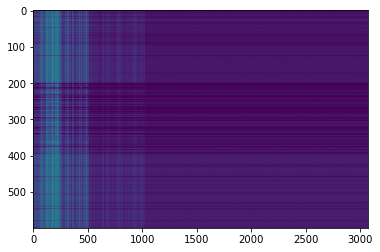

AUC      pAUC
Source_0  0.493900  0.521053
Source_1  0.475600  0.511579
Source_2  0.463700  0.563158
Target_0  0.554100  0.566316
Target_1  0.586300  0.585789
Target_2  0.536400  0.484737
mean      0.518333  0.538772
h_mean    0.514646  0.536409

2021-05-22 00:37:28,985 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:855.476257, val_AUC_hmean:0.514646, val_pAUC_hmean:0.536409, best_flag:True
2021-05-22 00:37:28,986 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.75it/s]
2021-05-22 00:37:29,378 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:37:29,536 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.78it/s]


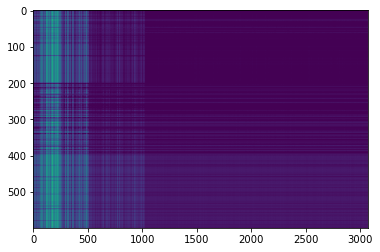

AUC      pAUC
Source_0  0.616900  0.570000
Source_1  0.500400  0.526316
Source_2  0.663600  0.663684
Target_0  0.586300  0.603158
Target_1  0.661500  0.551579
Target_2  0.472000  0.488421
mean      0.583450  0.567193
h_mean    0.573487  0.561826

2021-05-22 00:37:30,416 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:835.089142, val_AUC_hmean:0.573487, val_pAUC_hmean:0.561826, best_flag:True
2021-05-22 00:37:30,417 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.92it/s]
2021-05-22 00:37:30,820 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
2021-05-22 00:37:30,975 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.30it/s]
2021-05-22 00:37:31,149 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:816.912470, val_AUC_hmean:0.552129, val_pAUC_hmean:0.554602, best_flag:False
2021-05-22 00:37:31,150 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.41it/s]
2021-05-22 00:37:31,547 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
2021-05-22 00:37:31,705 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.94it/s]
2021-05-22 00:37:

100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
2021-05-22 00:37:42,498 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:37:42,658 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:590.603312, val_AUC_hmean:0.554874, val_pAUC_hmean:0.544858, best_flag:False
2021-05-22 00:37:42,659 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.66it/s]
2021-05-22 00:37:43,052 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.73it/s]
2021-05-22 00:37:43,209 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]
2021-05-22 00:37:43,373 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:578.227529, val_AUC_hmean:0.570537, val_pAUC_hmean:0.534071, best_flag:False
2021-05-22 00:37:43,374 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.10it/s]
2021-05-22 00:37:43,776 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 29.18it/s]
2021-05-22 00:37:54,623 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
2021-05-22 00:37:54,783 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.14it/s]
2021-05-22 00:37:54,949 - pytorch_modeler.py - INFO - epoch:45/300, train_losses:422.313304, val_AUC_hmean:0.570410, val_pAUC_hmean:0.548082, best_flag:False
2021-05-22 00:37:54,950 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.04it/s]
2021-05-22 00:37:55,352 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
2021-05-22 00:37:55,519 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:37:55,677 - pytorch_modeler.py - INFO - epoch:46/300, train_losses:412.197289, val_AUC_hmean:0.570590, val_pAUC_hmean:0.547876, best_flag:False
2021-05-22 00:37:55,678 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:38:06,498 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.62it/s]
2021-05-22 00:38:06,893 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
2021-05-22 00:38:07,049 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.77it/s]
2021-05-22 00:38:07,217 - pytorch_modeler.py - INFO - epoch:62/300, train_losses:301.590446, val_AUC_hmean:0.567675, val_pAUC_hmean:0.555731, best_flag:False
2021-05-22 00:38:07,218 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.21it/s]
2021-05-22 00:38:07,618 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.18it/s]
2021-05-22 00:38:07,780 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
2021-05-22 00:38:07,939 - pytorch_modeler.py - INFO - epoch:63/300, train_losses:296.241941, val_AUC_hmean:0.569989, val_pAUC_hmean:0.555008, best_flag:False
2021-05-22 00:38

100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
2021-05-22 00:38:18,759 - pytorch_modeler.py - INFO - epoch:78/300, train_losses:222.078242, val_AUC_hmean:0.570453, val_pAUC_hmean:0.547874, best_flag:False
2021-05-22 00:38:18,760 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.48it/s]
2021-05-22 00:38:19,156 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:38:19,313 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.95it/s]
2021-05-22 00:38:19,470 - pytorch_modeler.py - INFO - epoch:79/300, train_losses:217.823664, val_AUC_hmean:0.565438, val_pAUC_hmean:0.547773, best_flag:False
2021-05-22 00:38:19,471 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.40it/s]
2021-05-22 00:38:19,881 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:38:20,042 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
2021-05-22 00:38:30,941 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
2021-05-22 00:38:31,098 - pytorch_modeler.py - INFO - epoch:95/300, train_losses:160.154591, val_AUC_hmean:0.575612, val_pAUC_hmean:0.554399, best_flag:False
2021-05-22 00:38:31,100 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.22it/s]
2021-05-22 00:38:31,499 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.54it/s]
2021-05-22 00:38:31,667 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.85it/s]
2021-05-22 00:38:31,826 - pytorch_modeler.py - INFO - epoch:96/300, train_losses:156.913943, val_AUC_hmean:0.575367, val_pAUC_hmean:0.555357, best_flag:False
2021-05-22 00:38:31,827 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.52it/s]
2021-05-22 00:38:32,223 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

2021-05-22 00:38:42,742 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.41it/s]
2021-05-22 00:38:43,139 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:38:43,298 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.60it/s]
2021-05-22 00:38:43,467 - pytorch_modeler.py - INFO - epoch:112/300, train_losses:115.741154, val_AUC_hmean:0.559965, val_pAUC_hmean:0.539458, best_flag:False
2021-05-22 00:38:43,469 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.49it/s]
2021-05-22 00:38:43,864 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
2021-05-22 00:38:44,025 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
2021-05-22 00:38:44,182 - pytorch_modeler.py - INFO - epoch:113/300, train_losses:113.207467, val_AUC_hmean:0.586147, val_pAUC_hmean:0.555918, best_flag:False
2021-05-22 00:

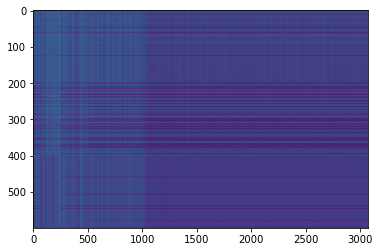

AUC      pAUC
Source_0  0.509300  0.572632
Source_1  0.571200  0.568947
Source_2  0.590000  0.673684
Target_0  0.534900  0.582632
Target_1  0.605500  0.563684
Target_2  0.506800  0.515789
mean      0.552950  0.579561
h_mean    0.550292  0.575954

2021-05-22 00:38:52,964 - pytorch_modeler.py - INFO - epoch:124/300, train_losses:90.585028, val_AUC_hmean:0.550292, val_pAUC_hmean:0.575954, best_flag:True
2021-05-22 00:38:52,965 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.80it/s]
2021-05-22 00:38:53,357 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
2021-05-22 00:38:53,518 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.07it/s]
2021-05-22 00:38:53,694 - pytorch_modeler.py - INFO - epoch:125/300, train_losses:89.763372, val_AUC_hmean:0.554454, val_pAUC_hmean:0.565487, best_flag:False
2021-05-22 00:38:53,695 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.48it/s]
2021-05-22 00:38:54,091 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.54it/s]
2021-05-22 00:38:54,259 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.60it/s]
2021-05-22 00:38:

100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:39:05,407 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:39:05,566 - pytorch_modeler.py - INFO - epoch:141/300, train_losses:65.362858, val_AUC_hmean:0.521913, val_pAUC_hmean:0.543442, best_flag:False
2021-05-22 00:39:05,567 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.81it/s]
2021-05-22 00:39:05,972 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.58it/s]
2021-05-22 00:39:06,139 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
2021-05-22 00:39:06,296 - pytorch_modeler.py - INFO - epoch:142/300, train_losses:64.131445, val_AUC_hmean:0.548042, val_pAUC_hmean:0.529261, best_flag:False
2021-05-22 00:39:06,298 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.33it/s]
2021-05-22 00:39:06,695 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.69it/s]
2021-05-22 00:39:18,089 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]
2021-05-22 00:39:18,250 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.81it/s]
2021-05-22 00:39:18,420 - pytorch_modeler.py - INFO - epoch:158/300, train_losses:46.424311, val_AUC_hmean:0.546640, val_pAUC_hmean:0.526540, best_flag:False
2021-05-22 00:39:18,422 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.47it/s]
2021-05-22 00:39:18,818 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:39:18,979 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
2021-05-22 00:39:19,147 - pytorch_modeler.py - INFO - epoch:159/300, train_losses:45.393634, val_AUC_hmean:0.546146, val_pAUC_hmean:0.530077, best_flag:False
2021-05-22 00:39:19,149 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:39:30,460 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.24it/s]
2021-05-22 00:39:30,859 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
2021-05-22 00:39:31,024 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
2021-05-22 00:39:31,213 - pytorch_modeler.py - INFO - epoch:175/300, train_losses:38.252277, val_AUC_hmean:0.539231, val_pAUC_hmean:0.519793, best_flag:False
2021-05-22 00:39:31,214 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.18it/s]
2021-05-22 00:39:31,614 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.68it/s]
2021-05-22 00:39:31,780 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.48it/s]
2021-05-22 00:39:31,952 - pytorch_modeler.py - INFO - epoch:176/300, train_losses:35.012035, val_AUC_hmean:0.534590, val_pAUC_hmean:0.516538, best_flag:False
2021-05-22 00:39

100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
2021-05-22 00:39:43,172 - pytorch_modeler.py - INFO - epoch:191/300, train_losses:23.686790, val_AUC_hmean:0.539025, val_pAUC_hmean:0.524253, best_flag:False
2021-05-22 00:39:43,173 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.66it/s]
2021-05-22 00:39:43,566 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2021-05-22 00:39:43,722 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
2021-05-22 00:39:43,882 - pytorch_modeler.py - INFO - epoch:192/300, train_losses:23.466592, val_AUC_hmean:0.537748, val_pAUC_hmean:0.523160, best_flag:False
2021-05-22 00:39:43,883 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.24it/s]
2021-05-22 00:39:44,270 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.60it/s]
2021-05-22 00:39:44,439 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 13.47it/s]
2021-05-22 00:39:55,662 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.53it/s]
2021-05-22 00:39:55,824 - pytorch_modeler.py - INFO - epoch:208/300, train_losses:18.002141, val_AUC_hmean:0.538632, val_pAUC_hmean:0.525023, best_flag:False
2021-05-22 00:39:55,825 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.33it/s]
2021-05-22 00:39:56,236 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.78it/s]
2021-05-22 00:39:56,401 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
2021-05-22 00:39:56,559 - pytorch_modeler.py - INFO - epoch:209/300, train_losses:17.120594, val_AUC_hmean:0.547445, val_pAUC_hmean:0.533263, best_flag:False
2021-05-22 00:39:56,560 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.38it/s]
2021-05-22 00:39:56,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.32it/s]
2021-05-22 00:40:07,980 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.09it/s]
2021-05-22 00:40:08,144 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:40:08,306 - pytorch_modeler.py - INFO - epoch:225/300, train_losses:12.618194, val_AUC_hmean:0.553426, val_pAUC_hmean:0.531111, best_flag:False
2021-05-22 00:40:08,307 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.46it/s]
2021-05-22 00:40:08,703 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
2021-05-22 00:40:08,863 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:40:09,024 - pytorch_modeler.py - INFO - epoch:226/300, train_losses:12.269367, val_AUC_hmean:0.522127, val_pAUC_hmean:0.523704, best_flag:False
2021-05-22 00:40:09,025 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:40:19,909 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.44it/s]
2021-05-22 00:40:20,305 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
2021-05-22 00:40:20,464 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.55it/s]
2021-05-22 00:40:20,624 - pytorch_modeler.py - INFO - epoch:242/300, train_losses:9.012404, val_AUC_hmean:0.541156, val_pAUC_hmean:0.525871, best_flag:False
2021-05-22 00:40:20,626 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.35it/s]
2021-05-22 00:40:21,023 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.81it/s]
2021-05-22 00:40:21,187 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
2021-05-22 00:40:21,348 - pytorch_modeler.py - INFO - epoch:243/300, train_losses:9.001241, val_AUC_hmean:0.541581, val_pAUC_hmean:0.527792, best_flag:False
2021-05-22 00:40:2

2021-05-22 00:40:32,251 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.68it/s]
2021-05-22 00:40:32,658 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
2021-05-22 00:40:32,826 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.62it/s]
2021-05-22 00:40:32,987 - pytorch_modeler.py - INFO - epoch:259/300, train_losses:6.503371, val_AUC_hmean:0.544424, val_pAUC_hmean:0.530091, best_flag:False
2021-05-22 00:40:32,988 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.60it/s]
2021-05-22 00:40:33,383 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.04it/s]
2021-05-22 00:40:33,555 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-22 00:40:33,758 - pytorch_modeler.py - INFO - epoch:260/300, train_losses:5.965586, val_AUC_hmean:0.544515, val_pAUC_hmean:0.530032, best_flag:False
2021-05-22 00:40:3

2021-05-22 00:40:45,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.61it/s]
2021-05-22 00:40:45,472 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
2021-05-22 00:40:45,637 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
2021-05-22 00:40:45,802 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:4.761234, val_AUC_hmean:0.560327, val_pAUC_hmean:0.542697, best_flag:False
2021-05-22 00:40:45,804 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.22it/s]
2021-05-22 00:40:46,217 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
2021-05-22 00:40:46,380 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.20it/s]
2021-05-22 00:40:46,546 - pytorch_modeler.py - INFO - epoch:277/300, train_losses:4.929863, val_AUC_hmean:0.553052, val_pAUC_hmean:0.539343, best_flag:False
2021-05-22 00:40:4

2021-05-22 00:40:57,593 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.08it/s]
2021-05-22 00:40:57,995 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.76it/s]
2021-05-22 00:40:58,164 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.63it/s]
2021-05-22 00:40:58,360 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:4.707580, val_AUC_hmean:0.575812, val_pAUC_hmean:0.532331, best_flag:False
2021-05-22 00:40:58,361 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.45it/s]
2021-05-22 00:40:58,771 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.13it/s]
2021-05-22 00:40:58,958 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.64it/s]
2021-05-22 00:40:59,127 - pytorch_modeler.py - INFO - epoch:294/300, train_losses:5.760087, val_AUC_hmean:0.564654, val_pAUC_hmean:0.526654, best_flag:False
2021-05-22 00:40:5

AUC      pAUC
Source_0  0.509300  0.572632
Source_1  0.571200  0.568947
Source_2  0.590000  0.673684
Target_0  0.534900  0.582632
Target_1  0.605500  0.563684
Target_2  0.506800  0.515789
mean      0.552950  0.579561
h_mean    0.550292  0.575954

2021-05-22 00:41:03,495 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-05-22 00:41:03,496 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-22 00:41:03,528 - 00_train.py - INFO - TRAINING


elapsed time: 224.834191322 [sec]
use: cuda:0


2021-05-22 00:41:03,717 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.72it/s]
2021-05-22 00:41:04,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:41:04,285 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.37it/s]


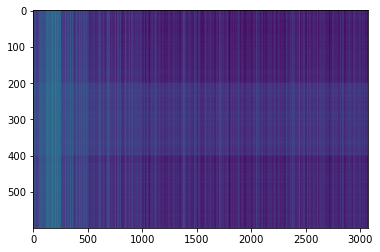

AUC      pAUC
Source_0  0.333800  0.484211
Source_1  0.457800  0.482105
Source_2  0.364900  0.478947
Target_0  0.496500  0.525789
Target_1  0.514200  0.494211
Target_2  0.458100  0.499474
mean      0.437550  0.494123
h_mean    0.426669  0.493632

2021-05-22 00:41:05,176 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1949.351034, val_AUC_hmean:0.426669, val_pAUC_hmean:0.493632, best_flag:True
2021-05-22 00:41:05,176 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.10it/s]
2021-05-22 00:41:05,577 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:41:05,739 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.82it/s]


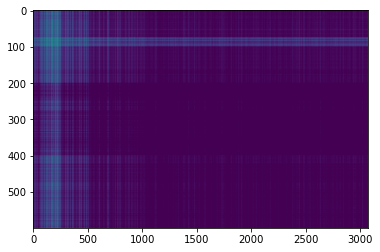

AUC      pAUC
Source_0  0.43200  0.473684
Source_1  0.53110  0.547368
Source_2  0.37010  0.477368
Target_0  0.49850  0.592632
Target_1  0.53720  0.544737
Target_2  0.44540  0.497368
mean      0.46905  0.522193
h_mean    0.46110  0.518736

2021-05-22 00:41:06,631 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1383.323934, val_AUC_hmean:0.461100, val_pAUC_hmean:0.518736, best_flag:True
2021-05-22 00:41:06,632 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.13it/s]
2021-05-22 00:41:07,032 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2021-05-22 00:41:07,188 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.67it/s]


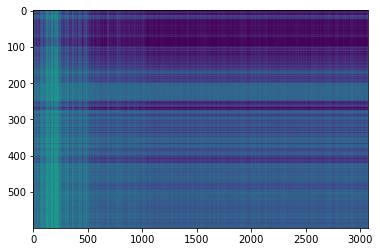

AUC      pAUC
Source_0  0.393200  0.599474
Source_1  0.628700  0.499474
Source_2  0.770400  0.679474
Target_0  0.181700  0.477368
Target_1  0.530600  0.473684
Target_2  0.396600  0.494211
mean      0.483533  0.537281
h_mean    0.391096  0.527643

2021-05-22 00:41:08,126 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1213.810842, val_AUC_hmean:0.391096, val_pAUC_hmean:0.527643, best_flag:True
2021-05-22 00:41:08,127 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.22it/s]
2021-05-22 00:41:08,526 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.97it/s]
2021-05-22 00:41:08,691 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.04it/s]
2021-05-22 00:41:08,857 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1127.472555, val_AUC_hmean:0.488032, val_pAUC_hmean:0.522428, best_flag:False
2021-05-22 00:41:08,858 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.09it/s]
2021-05-22 00:41:09,259 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
2021-05-22 00:41:09,420 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


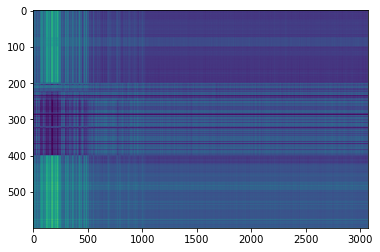

AUC      pAUC
Source_0  0.470700  0.510526
Source_1  0.421000  0.507895
Source_2  0.526600  0.557368
Target_0  0.819600  0.637895
Target_1  0.448000  0.551053
Target_2  0.386600  0.485263
mean      0.512083  0.541667
h_mean    0.482405  0.537397

2021-05-22 00:41:10,362 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:1085.279989, val_AUC_hmean:0.482405, val_pAUC_hmean:0.537397, best_flag:True
2021-05-22 00:41:10,363 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.47it/s]
2021-05-22 00:41:10,759 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
2021-05-22 00:41:10,919 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


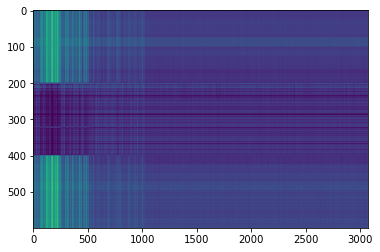

AUC      pAUC
Source_0  0.616800  0.666842
Source_1  0.443800  0.538421
Source_2  0.186700  0.481053
Target_0  0.837500  0.624211
Target_1  0.427200  0.553684
Target_2  0.386800  0.498947
mean      0.483133  0.560526
h_mean    0.390857  0.553098

2021-05-22 00:41:11,855 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1048.297028, val_AUC_hmean:0.390857, val_pAUC_hmean:0.553098, best_flag:True
2021-05-22 00:41:11,856 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.83it/s]
2021-05-22 00:41:12,260 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.91it/s]
2021-05-22 00:41:12,424 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:41:12,588 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1012.106206, val_AUC_hmean:0.362053, val_pAUC_hmean:0.532082, best_flag:False
2021-05-22 00:41:12,589 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.95it/s]
2021-05-22 00:41:12,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.03it/s]
2021-05-22 00:41:13,157 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.67it/s]
2021-05-22 00:41:

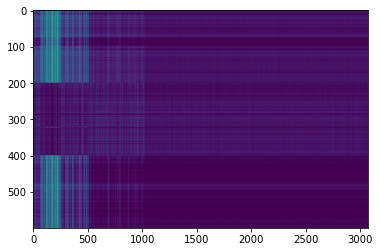

AUC      pAUC
Source_0  0.408900  0.546316
Source_1  0.365600  0.523158
Source_2  0.430400  0.552632
Target_0  0.806900  0.747895
Target_1  0.443100  0.528421
Target_2  0.486900  0.505263
mean      0.490300  0.567281
h_mean    0.459623  0.557615

2021-05-22 00:41:14,795 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:971.717896, val_AUC_hmean:0.459623, val_pAUC_hmean:0.557615, best_flag:True
2021-05-22 00:41:14,797 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.34it/s]
2021-05-22 00:41:15,208 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.05it/s]
2021-05-22 00:41:15,382 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
2021-05-22 00:41:15,547 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:941.016836, val_AUC_hmean:0.358141, val_pAUC_hmean:0.508953, best_flag:False
2021-05-22 00:41:15,549 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.46it/s]
2021-05-22 00:41:15,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.70it/s]
2021-05-22 00:41:16,126 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.34it/s]
2021-05-22 00:41:1

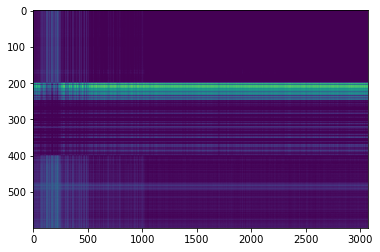

AUC      pAUC
Source_0  0.465800  0.489474
Source_1  0.630700  0.629474
Source_2  0.179800  0.493158
Target_0  0.872800  0.728421
Target_1  0.646600  0.667368
Target_2  0.562100  0.529474
mean      0.559633  0.589561
h_mean    0.435874  0.575854

2021-05-22 00:41:19,984 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:834.530217, val_AUC_hmean:0.435874, val_pAUC_hmean:0.575854, best_flag:True
2021-05-22 00:41:19,985 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.06it/s]
2021-05-22 00:41:20,386 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.17it/s]
2021-05-22 00:41:20,548 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
2021-05-22 00:41:20,711 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:819.573771, val_AUC_hmean:0.337168, val_pAUC_hmean:0.548688, best_flag:False
2021-05-22 00:41:20,712 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.84it/s]
2021-05-22 00:41:21,117 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.45it/s]
2021-05-22 00:41:21,286 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
2021-05-22 00:41:

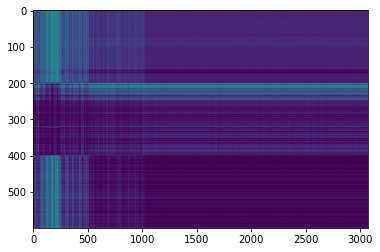

AUC      pAUC
Source_0  0.446600  0.505263
Source_1  0.659700  0.682105
Source_2  0.186500  0.494211
Target_0  0.849500  0.711579
Target_1  0.615600  0.677895
Target_2  0.524000  0.495789
mean      0.546983  0.594474
h_mean    0.433937  0.578809

2021-05-22 00:41:25,137 - pytorch_modeler.py - INFO - epoch:21/300, train_losses:735.251719, val_AUC_hmean:0.433937, val_pAUC_hmean:0.578809, best_flag:True
2021-05-22 00:41:25,137 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.29it/s]
2021-05-22 00:41:25,550 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.51it/s]
2021-05-22 00:41:25,729 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.93it/s]
2021-05-22 00:41:25,896 - pytorch_modeler.py - INFO - epoch:22/300, train_losses:718.570104, val_AUC_hmean:0.347922, val_pAUC_hmean:0.554807, best_flag:False
2021-05-22 00:41:25,897 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.20it/s]
2021-05-22 00:41:26,297 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
2021-05-22 00:41:26,457 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.26it/s]
2021-05-22 00:41:

100%|██████████| 2/2 [00:00<00:00, 13.60it/s]
2021-05-22 00:41:37,486 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.98it/s]
2021-05-22 00:41:37,653 - pytorch_modeler.py - INFO - epoch:38/300, train_losses:527.351252, val_AUC_hmean:0.414030, val_pAUC_hmean:0.521039, best_flag:False
2021-05-22 00:41:37,654 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.81it/s]
2021-05-22 00:41:38,059 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.52it/s]
2021-05-22 00:41:38,227 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:41:38,391 - pytorch_modeler.py - INFO - epoch:39/300, train_losses:517.435852, val_AUC_hmean:0.464422, val_pAUC_hmean:0.523017, best_flag:False
2021-05-22 00:41:38,393 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.91it/s]
2021-05-22 00:41:38,797 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 29.98it/s]
2021-05-22 00:41:49,860 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.10it/s]
2021-05-22 00:41:50,032 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.83it/s]
2021-05-22 00:41:50,199 - pytorch_modeler.py - INFO - epoch:55/300, train_losses:384.575686, val_AUC_hmean:0.454657, val_pAUC_hmean:0.526063, best_flag:False
2021-05-22 00:41:50,201 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.26it/s]
2021-05-22 00:41:50,599 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
2021-05-22 00:41:50,762 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.08it/s]
2021-05-22 00:41:50,939 - pytorch_modeler.py - INFO - epoch:56/300, train_losses:377.454943, val_AUC_hmean:0.499293, val_pAUC_hmean:0.514683, best_flag:False
2021-05-22 00:41:50,940 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:42:01,994 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.00it/s]
2021-05-22 00:42:02,396 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.86it/s]
2021-05-22 00:42:02,561 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:42:02,723 - pytorch_modeler.py - INFO - epoch:72/300, train_losses:279.266098, val_AUC_hmean:0.475585, val_pAUC_hmean:0.520666, best_flag:False
2021-05-22 00:42:02,724 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.48it/s]
2021-05-22 00:42:03,120 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.26it/s]
2021-05-22 00:42:03,290 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
2021-05-22 00:42:03,453 - pytorch_modeler.py - INFO - epoch:73/300, train_losses:274.534190, val_AUC_hmean:0.444877, val_pAUC_hmean:0.524377, best_flag:False
2021-05-22 00:42

100%|██████████| 2/2 [00:00<00:00, 13.38it/s]
2021-05-22 00:42:14,741 - pytorch_modeler.py - INFO - epoch:88/300, train_losses:207.814968, val_AUC_hmean:0.456832, val_pAUC_hmean:0.510369, best_flag:False
2021-05-22 00:42:14,742 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.66it/s]
2021-05-22 00:42:15,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.00it/s]
2021-05-22 00:42:15,356 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.00it/s]
2021-05-22 00:42:15,534 - pytorch_modeler.py - INFO - epoch:89/300, train_losses:203.587962, val_AUC_hmean:0.566203, val_pAUC_hmean:0.529738, best_flag:False
2021-05-22 00:42:15,535 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.13it/s]
2021-05-22 00:42:15,964 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.85it/s]
2021-05-22 00:42:16,129 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
2021-05-22 00:42:27,662 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.89it/s]
2021-05-22 00:42:27,842 - pytorch_modeler.py - INFO - epoch:105/300, train_losses:151.444377, val_AUC_hmean:0.456922, val_pAUC_hmean:0.523348, best_flag:False
2021-05-22 00:42:27,843 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.87it/s]
2021-05-22 00:42:28,246 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.47it/s]
2021-05-22 00:42:28,428 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.61it/s]
2021-05-22 00:42:28,610 - pytorch_modeler.py - INFO - epoch:106/300, train_losses:148.563814, val_AUC_hmean:0.453351, val_pAUC_hmean:0.523861, best_flag:False
2021-05-22 00:42:28,611 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.30it/s]
2021-05-22 00:42:29,053 - pytorch_modeler.py - INFO - valid_source
100%|█████████

2021-05-22 00:42:40,256 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.33it/s]
2021-05-22 00:42:40,682 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.87it/s]
2021-05-22 00:42:40,847 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
2021-05-22 00:42:41,013 - pytorch_modeler.py - INFO - epoch:122/300, train_losses:110.400623, val_AUC_hmean:0.442113, val_pAUC_hmean:0.523114, best_flag:False
2021-05-22 00:42:41,014 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.14it/s]
2021-05-22 00:42:41,443 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
2021-05-22 00:42:41,618 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.74it/s]
2021-05-22 00:42:41,815 - pytorch_modeler.py - INFO - epoch:123/300, train_losses:107.644973, val_AUC_hmean:0.445881, val_pAUC_hmean:0.523114, best_flag:False
2021-05-22 00:

100%|██████████| 2/2 [00:00<00:00, 12.91it/s]
2021-05-22 00:42:53,502 - pytorch_modeler.py - INFO - epoch:138/300, train_losses:80.895191, val_AUC_hmean:0.444735, val_pAUC_hmean:0.521648, best_flag:False
2021-05-22 00:42:53,504 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.21it/s]
2021-05-22 00:42:53,948 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.67it/s]
2021-05-22 00:42:54,139 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.85it/s]
2021-05-22 00:42:54,307 - pytorch_modeler.py - INFO - epoch:139/300, train_losses:79.507817, val_AUC_hmean:0.432605, val_pAUC_hmean:0.522647, best_flag:False
2021-05-22 00:42:54,308 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.01it/s]
2021-05-22 00:42:54,755 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.43it/s]
2021-05-22 00:42:54,924 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 12.45it/s]
2021-05-22 00:43:06,635 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
2021-05-22 00:43:06,798 - pytorch_modeler.py - INFO - epoch:155/300, train_losses:58.940394, val_AUC_hmean:0.440164, val_pAUC_hmean:0.521662, best_flag:False
2021-05-22 00:43:06,800 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.54it/s]
2021-05-22 00:43:07,209 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.31it/s]
2021-05-22 00:43:07,380 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.18it/s]
2021-05-22 00:43:07,547 - pytorch_modeler.py - INFO - epoch:156/300, train_losses:57.105972, val_AUC_hmean:0.439515, val_pAUC_hmean:0.521424, best_flag:False
2021-05-22 00:43:07,548 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.62it/s]
2021-05-22 00:43:07,955 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.42it/s]
2021-05-22 00:43:19,504 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.52it/s]
2021-05-22 00:43:19,674 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.54it/s]
2021-05-22 00:43:19,844 - pytorch_modeler.py - INFO - epoch:172/300, train_losses:44.791119, val_AUC_hmean:0.432111, val_pAUC_hmean:0.521643, best_flag:False
2021-05-22 00:43:19,845 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.01it/s]
2021-05-22 00:43:20,260 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
2021-05-22 00:43:20,435 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.08it/s]
2021-05-22 00:43:20,612 - pytorch_modeler.py - INFO - epoch:173/300, train_losses:42.097000, val_AUC_hmean:0.442664, val_pAUC_hmean:0.521135, best_flag:False
2021-05-22 00:43:20,613 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:43:31,761 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.51it/s]
2021-05-22 00:43:32,170 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
2021-05-22 00:43:32,335 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
2021-05-22 00:43:32,531 - pytorch_modeler.py - INFO - epoch:189/300, train_losses:29.964044, val_AUC_hmean:0.432419, val_pAUC_hmean:0.521217, best_flag:False
2021-05-22 00:43:32,532 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.51it/s]
2021-05-22 00:43:32,941 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.45it/s]
2021-05-22 00:43:33,109 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
2021-05-22 00:43:33,286 - pytorch_modeler.py - INFO - epoch:190/300, train_losses:29.846508, val_AUC_hmean:0.433410, val_pAUC_hmean:0.521399, best_flag:False
2021-05-22 00:43

100%|██████████| 2/2 [00:00<00:00, 14.20it/s]
2021-05-22 00:43:44,357 - pytorch_modeler.py - INFO - epoch:205/300, train_losses:21.866160, val_AUC_hmean:0.430635, val_pAUC_hmean:0.521624, best_flag:False
2021-05-22 00:43:44,358 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.47it/s]
2021-05-22 00:43:44,769 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.46it/s]
2021-05-22 00:43:44,939 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
2021-05-22 00:43:45,104 - pytorch_modeler.py - INFO - epoch:206/300, train_losses:21.702907, val_AUC_hmean:0.446214, val_pAUC_hmean:0.520686, best_flag:False
2021-05-22 00:43:45,105 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.99it/s]
2021-05-22 00:43:45,507 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
2021-05-22 00:43:45,671 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.04it/s]
2021-05-22 00:43:56,761 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.06it/s]
2021-05-22 00:43:56,925 - pytorch_modeler.py - INFO - epoch:222/300, train_losses:16.669280, val_AUC_hmean:0.442680, val_pAUC_hmean:0.521689, best_flag:False
2021-05-22 00:43:56,926 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.14it/s]
2021-05-22 00:43:57,327 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.39it/s]
2021-05-22 00:43:57,498 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
2021-05-22 00:43:57,673 - pytorch_modeler.py - INFO - epoch:223/300, train_losses:15.676886, val_AUC_hmean:0.440466, val_pAUC_hmean:0.521222, best_flag:False
2021-05-22 00:43:57,674 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.75it/s]
2021-05-22 00:43:58,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 29.61it/s]
2021-05-22 00:44:09,250 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
2021-05-22 00:44:09,414 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.82it/s]
2021-05-22 00:44:09,593 - pytorch_modeler.py - INFO - epoch:239/300, train_losses:11.211553, val_AUC_hmean:0.433976, val_pAUC_hmean:0.521320, best_flag:False
2021-05-22 00:44:09,594 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.09it/s]
2021-05-22 00:44:10,009 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.13it/s]
2021-05-22 00:44:10,181 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
2021-05-22 00:44:10,343 - pytorch_modeler.py - INFO - epoch:240/300, train_losses:11.066220, val_AUC_hmean:0.434962, val_pAUC_hmean:0.521683, best_flag:False
2021-05-22 00:44:10,344 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:44:21,512 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.38it/s]
2021-05-22 00:44:21,910 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.18it/s]
2021-05-22 00:44:22,080 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:44:22,242 - pytorch_modeler.py - INFO - epoch:256/300, train_losses:7.852839, val_AUC_hmean:0.437798, val_pAUC_hmean:0.521631, best_flag:False
2021-05-22 00:44:22,243 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.45it/s]
2021-05-22 00:44:22,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.28it/s]
2021-05-22 00:44:22,824 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
2021-05-22 00:44:22,989 - pytorch_modeler.py - INFO - epoch:257/300, train_losses:7.745922, val_AUC_hmean:0.427097, val_pAUC_hmean:0.522179, best_flag:False
2021-05-22 00:44:2

2021-05-22 00:44:34,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.37it/s]
2021-05-22 00:44:34,573 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.98it/s]
2021-05-22 00:44:34,736 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
2021-05-22 00:44:34,908 - pytorch_modeler.py - INFO - epoch:273/300, train_losses:5.654150, val_AUC_hmean:0.434938, val_pAUC_hmean:0.520998, best_flag:False
2021-05-22 00:44:34,909 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.29it/s]
2021-05-22 00:44:35,307 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.53it/s]
2021-05-22 00:44:35,475 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.11it/s]
2021-05-22 00:44:35,640 - pytorch_modeler.py - INFO - epoch:274/300, train_losses:5.615725, val_AUC_hmean:0.440178, val_pAUC_hmean:0.521042, best_flag:False
2021-05-22 00:44:3

2021-05-22 00:44:46,805 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.06it/s]
2021-05-22 00:44:47,206 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.74it/s]
2021-05-22 00:44:47,385 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.56it/s]
2021-05-22 00:44:47,555 - pytorch_modeler.py - INFO - epoch:290/300, train_losses:6.563715, val_AUC_hmean:0.442274, val_pAUC_hmean:0.521603, best_flag:False
2021-05-22 00:44:47,556 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.70it/s]
2021-05-22 00:44:47,962 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.28it/s]
2021-05-22 00:44:48,132 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.82it/s]
2021-05-22 00:44:48,298 - pytorch_modeler.py - INFO - epoch:291/300, train_losses:6.186179, val_AUC_hmean:0.443920, val_pAUC_hmean:0.520824, best_flag:False
2021-05-22 00:44:4

AUC      pAUC
Source_0  0.446600  0.505263
Source_1  0.659700  0.682105
Source_2  0.186500  0.494211
Target_0  0.849500  0.711579
Target_1  0.615600  0.677895
Target_2  0.524000  0.495789
mean      0.546983  0.594474
h_mean    0.433937  0.578809

2021-05-22 00:44:55,064 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-05-22 00:44:55,065 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-22 00:44:55,099 - 00_train.py - INFO - TRAINING


elapsed time: 231.568711519 [sec]
use: cuda:0


2021-05-22 00:44:55,286 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.69it/s]
2021-05-22 00:44:55,692 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.41it/s]
2021-05-22 00:44:55,864 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


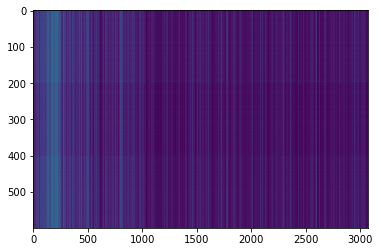

AUC      pAUC
Source_0  0.519300  0.502105
Source_1  0.332000  0.484211
Source_2  0.498800  0.512105
Target_0  0.439400  0.502632
Target_1  0.514200  0.494737
Target_2  0.489100  0.506316
mean      0.465467  0.500351
h_mean    0.454280  0.500191

2021-05-22 00:44:56,816 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2195.159149, val_AUC_hmean:0.454280, val_pAUC_hmean:0.500191, best_flag:True
2021-05-22 00:44:56,817 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.82it/s]
2021-05-22 00:44:57,222 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.80it/s]
2021-05-22 00:44:57,395 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


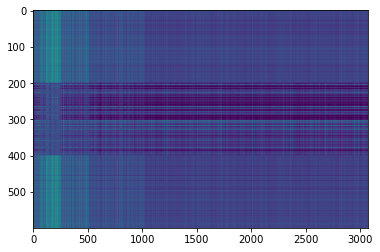

AUC      pAUC
Source_0  0.394900  0.491579
Source_1  0.319000  0.513158
Source_2  0.502000  0.533684
Target_0  0.371800  0.487895
Target_1  0.328100  0.493158
Target_2  0.425200  0.494737
mean      0.390167  0.502368
h_mean    0.380991  0.501866

2021-05-22 00:44:58,464 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1527.618947, val_AUC_hmean:0.380991, val_pAUC_hmean:0.501866, best_flag:True
2021-05-22 00:44:58,465 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.66it/s]
2021-05-22 00:44:58,902 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.77it/s]
2021-05-22 00:44:59,092 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.69it/s]
2021-05-22 00:44:59,260 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1361.145955, val_AUC_hmean:0.334878, val_pAUC_hmean:0.493644, best_flag:False
2021-05-22 00:44:59,261 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.52it/s]
2021-05-22 00:44:59,670 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.29it/s]
2021-05-22 00:44:59,841 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


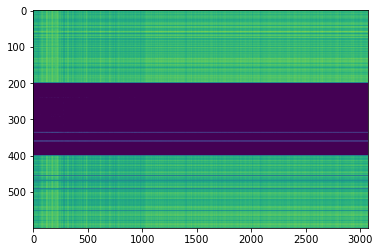

AUC      pAUC
Source_0  0.359700  0.496842
Source_1  0.426600  0.602632
Source_2  0.276400  0.476842
Target_0  0.417600  0.500000
Target_1  0.431600  0.489474
Target_2  0.361900  0.491579
mean      0.378967  0.509561
h_mean    0.369983  0.506479

2021-05-22 00:45:00,775 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1281.465861, val_AUC_hmean:0.369983, val_pAUC_hmean:0.506479, best_flag:True
2021-05-22 00:45:00,776 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.99it/s]
2021-05-22 00:45:01,179 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.50it/s]
2021-05-22 00:45:01,347 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.22it/s]


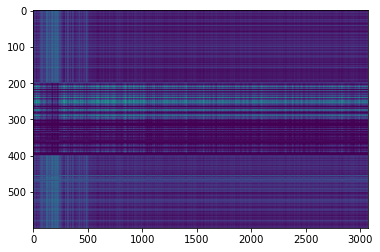

AUC      pAUC
Source_0  0.615800  0.621053
Source_1  0.132400  0.473684
Source_2  0.720200  0.621579
Target_0  0.597900  0.492632
Target_1  0.745800  0.668947
Target_2  0.619400  0.517368
mean      0.571917  0.565877
h_mean    0.394916  0.556187

2021-05-22 00:45:02,300 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:1211.813792, val_AUC_hmean:0.394916, val_pAUC_hmean:0.556187, best_flag:True
2021-05-22 00:45:02,301 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.49it/s]
2021-05-22 00:45:02,710 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.51it/s]
2021-05-22 00:45:02,878 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.86it/s]
2021-05-22 00:45:03,047 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1165.924784, val_AUC_hmean:0.445629, val_pAUC_hmean:0.525127, best_flag:False
2021-05-22 00:45:03,048 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.10it/s]
2021-05-22 00:45:03,449 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.35it/s]
2021-05-22 00:45:03,620 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.20it/s]
2021-05-22 00:45:

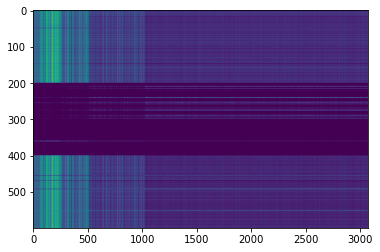

AUC      pAUC
Source_0  0.583000  0.603158
Source_1  0.601300  0.562632
Source_2  0.664800  0.592632
Target_0  0.504900  0.543684
Target_1  0.589900  0.593158
Target_2  0.553600  0.521579
mean      0.582917  0.569474
h_mean    0.578888  0.567905

2021-05-22 00:45:09,075 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:947.542552, val_AUC_hmean:0.578888, val_pAUC_hmean:0.567905, best_flag:True
2021-05-22 00:45:09,076 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.99it/s]
2021-05-22 00:45:09,624 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
2021-05-22 00:45:09,933 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  7.14it/s]
2021-05-22 00:45:10,236 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:924.139002, val_AUC_hmean:0.557388, val_pAUC_hmean:0.549880, best_flag:False
2021-05-22 00:45:10,237 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.92it/s]
2021-05-22 00:45:10,787 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
2021-05-22 00:45:11,099 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
2021-05-22 00:45:

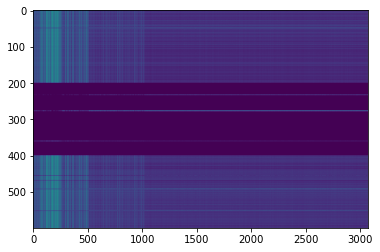

AUC      pAUC
Source_0  0.656200  0.635263
Source_1  0.774100  0.634737
Source_2  0.625700  0.587895
Target_0  0.713500  0.581053
Target_1  0.451300  0.504737
Target_2  0.466200  0.514737
mean      0.614500  0.576404
h_mean    0.589604  0.571669

2021-05-22 00:45:13,530 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:859.510717, val_AUC_hmean:0.589604, val_pAUC_hmean:0.571669, best_flag:True
2021-05-22 00:45:13,531 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.30it/s]
2021-05-22 00:45:13,957 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
2021-05-22 00:45:14,121 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:45:14,284 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:836.589778, val_AUC_hmean:0.534267, val_pAUC_hmean:0.548797, best_flag:False
2021-05-22 00:45:14,285 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.61it/s]
2021-05-22 00:45:14,680 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.18it/s]
2021-05-22 00:45:14,842 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.42it/s]
2021-05-22 00:45:

100%|██████████| 2/2 [00:00<00:00, 13.26it/s]
2021-05-22 00:45:25,879 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
2021-05-22 00:45:26,044 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:598.773931, val_AUC_hmean:0.472528, val_pAUC_hmean:0.525749, best_flag:False
2021-05-22 00:45:26,045 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.35it/s]
2021-05-22 00:45:26,443 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.57it/s]
2021-05-22 00:45:26,612 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.24it/s]
2021-05-22 00:45:26,786 - pytorch_modeler.py - INFO - epoch:34/300, train_losses:586.046651, val_AUC_hmean:0.482306, val_pAUC_hmean:0.527244, best_flag:False
2021-05-22 00:45:26,787 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.36it/s]
2021-05-22 00:45:27,185 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

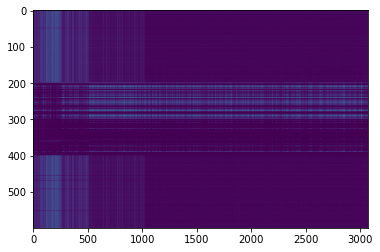

AUC      pAUC
Source_0  0.599600  0.619474
Source_1  0.521100  0.560526
Source_2  0.486500  0.558421
Target_0  0.644400  0.547895
Target_1  0.744900  0.667895
Target_2  0.428100  0.508421
mean      0.570767  0.577105
h_mean    0.551851  0.572609

2021-05-22 00:45:34,148 - pytorch_modeler.py - INFO - epoch:43/300, train_losses:494.603770, val_AUC_hmean:0.551851, val_pAUC_hmean:0.572609, best_flag:True
2021-05-22 00:45:34,149 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.33it/s]
2021-05-22 00:45:34,560 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]
2021-05-22 00:45:34,722 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.24it/s]
2021-05-22 00:45:34,908 - pytorch_modeler.py - INFO - epoch:44/300, train_losses:486.820129, val_AUC_hmean:0.500857, val_pAUC_hmean:0.549489, best_flag:False
2021-05-22 00:45:34,909 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.08it/s]
2021-05-22 00:45:35,324 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
2021-05-22 00:45:35,485 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.82it/s]
2021-05-22 00:45:

100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
2021-05-22 00:45:46,428 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.36it/s]
2021-05-22 00:45:46,602 - pytorch_modeler.py - INFO - epoch:60/300, train_losses:356.982018, val_AUC_hmean:0.491915, val_pAUC_hmean:0.528277, best_flag:False
2021-05-22 00:45:46,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.77it/s]
2021-05-22 00:45:47,008 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.09it/s]
2021-05-22 00:45:47,172 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:45:47,331 - pytorch_modeler.py - INFO - epoch:61/300, train_losses:349.417905, val_AUC_hmean:0.488198, val_pAUC_hmean:0.525634, best_flag:False
2021-05-22 00:45:47,333 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.38it/s]
2021-05-22 00:45:47,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.39it/s]
2021-05-22 00:45:58,699 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.73it/s]
2021-05-22 00:45:58,865 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:45:59,025 - pytorch_modeler.py - INFO - epoch:77/300, train_losses:257.663034, val_AUC_hmean:0.495892, val_pAUC_hmean:0.527929, best_flag:False
2021-05-22 00:45:59,026 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.98it/s]
2021-05-22 00:45:59,429 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.10it/s]
2021-05-22 00:45:59,591 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
2021-05-22 00:45:59,756 - pytorch_modeler.py - INFO - epoch:78/300, train_losses:252.859098, val_AUC_hmean:0.499650, val_pAUC_hmean:0.527974, best_flag:False
2021-05-22 00:45:59,757 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:46:10,782 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.24it/s]
2021-05-22 00:46:11,181 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.36it/s]
2021-05-22 00:46:11,360 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-22 00:46:11,573 - pytorch_modeler.py - INFO - epoch:94/300, train_losses:196.610280, val_AUC_hmean:0.472459, val_pAUC_hmean:0.523324, best_flag:False
2021-05-22 00:46:11,574 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.61it/s]
2021-05-22 00:46:11,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.76it/s]
2021-05-22 00:46:12,134 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
2021-05-22 00:46:12,300 - pytorch_modeler.py - INFO - epoch:95/300, train_losses:189.700273, val_AUC_hmean:0.478729, val_pAUC_hmean:0.526127, best_flag:False
2021-05-22 00:46

100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
2021-05-22 00:46:23,224 - pytorch_modeler.py - INFO - epoch:110/300, train_losses:137.370085, val_AUC_hmean:0.482467, val_pAUC_hmean:0.525874, best_flag:False
2021-05-22 00:46:23,226 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.79it/s]
2021-05-22 00:46:23,631 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
2021-05-22 00:46:23,791 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.62it/s]
2021-05-22 00:46:23,952 - pytorch_modeler.py - INFO - epoch:111/300, train_losses:134.224864, val_AUC_hmean:0.485457, val_pAUC_hmean:0.525542, best_flag:False
2021-05-22 00:46:23,953 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.25it/s]
2021-05-22 00:46:24,352 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
2021-05-22 00:46:24,513 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 12/12 [00:00<00:00, 29.95it/s]
2021-05-22 00:46:35,217 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
2021-05-22 00:46:35,381 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
2021-05-22 00:46:35,539 - pytorch_modeler.py - INFO - epoch:127/300, train_losses:99.468054, val_AUC_hmean:0.488114, val_pAUC_hmean:0.523965, best_flag:False
2021-05-22 00:46:35,540 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.37it/s]
2021-05-22 00:46:35,938 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:46:36,097 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.73it/s]
2021-05-22 00:46:36,264 - pytorch_modeler.py - INFO - epoch:128/300, train_losses:96.676539, val_AUC_hmean:0.482970, val_pAUC_hmean:0.525655, best_flag:False
2021-05-22 00:46:36,266 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:46:47,170 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.86it/s]
2021-05-22 00:46:47,574 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.19it/s]
2021-05-22 00:46:47,736 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
2021-05-22 00:46:47,900 - pytorch_modeler.py - INFO - epoch:144/300, train_losses:71.241982, val_AUC_hmean:0.485907, val_pAUC_hmean:0.527633, best_flag:False
2021-05-22 00:46:47,901 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.85it/s]
2021-05-22 00:46:48,305 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.10it/s]
2021-05-22 00:46:48,477 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
2021-05-22 00:46:48,641 - pytorch_modeler.py - INFO - epoch:145/300, train_losses:69.551083, val_AUC_hmean:0.493397, val_pAUC_hmean:0.527799, best_flag:False
2021-05-22 00:46

100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:46:59,714 - pytorch_modeler.py - INFO - epoch:160/300, train_losses:52.053287, val_AUC_hmean:0.486344, val_pAUC_hmean:0.525455, best_flag:False
2021-05-22 00:46:59,715 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.85it/s]
2021-05-22 00:47:00,119 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.39it/s]
2021-05-22 00:47:00,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.26it/s]
2021-05-22 00:47:00,442 - pytorch_modeler.py - INFO - epoch:161/300, train_losses:50.807140, val_AUC_hmean:0.489336, val_pAUC_hmean:0.525808, best_flag:False
2021-05-22 00:47:00,443 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.85it/s]
2021-05-22 00:47:00,847 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
2021-05-22 00:47:01,005 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
2021-05-22 00:47:11,876 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
2021-05-22 00:47:12,039 - pytorch_modeler.py - INFO - epoch:177/300, train_losses:36.558006, val_AUC_hmean:0.490892, val_pAUC_hmean:0.527197, best_flag:False
2021-05-22 00:47:12,040 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.10it/s]
2021-05-22 00:47:12,441 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.30it/s]
2021-05-22 00:47:12,600 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.43it/s]
2021-05-22 00:47:12,771 - pytorch_modeler.py - INFO - epoch:178/300, train_losses:35.676199, val_AUC_hmean:0.487959, val_pAUC_hmean:0.529110, best_flag:False
2021-05-22 00:47:12,772 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.61it/s]
2021-05-22 00:47:13,166 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 30.09it/s]
2021-05-22 00:47:24,080 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:47:24,238 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:47:24,401 - pytorch_modeler.py - INFO - epoch:194/300, train_losses:27.313489, val_AUC_hmean:0.487288, val_pAUC_hmean:0.524966, best_flag:False
2021-05-22 00:47:24,402 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.40it/s]
2021-05-22 00:47:24,798 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:47:24,959 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
2021-05-22 00:47:25,124 - pytorch_modeler.py - INFO - epoch:195/300, train_losses:26.284296, val_AUC_hmean:0.484769, val_pAUC_hmean:0.523297, best_flag:False
2021-05-22 00:47:25,125 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:47:36,016 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.41it/s]
2021-05-22 00:47:36,413 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
2021-05-22 00:47:36,571 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
2021-05-22 00:47:36,728 - pytorch_modeler.py - INFO - epoch:211/300, train_losses:18.460009, val_AUC_hmean:0.479396, val_pAUC_hmean:0.522593, best_flag:False
2021-05-22 00:47:36,730 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.65it/s]
2021-05-22 00:47:37,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:47:37,281 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
2021-05-22 00:47:37,440 - pytorch_modeler.py - INFO - epoch:212/300, train_losses:18.989608, val_AUC_hmean:0.486139, val_pAUC_hmean:0.523497, best_flag:False
2021-05-22 00:47

100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
2021-05-22 00:47:48,342 - pytorch_modeler.py - INFO - epoch:227/300, train_losses:13.528674, val_AUC_hmean:0.480677, val_pAUC_hmean:0.525361, best_flag:False
2021-05-22 00:47:48,343 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.97it/s]
2021-05-22 00:47:48,746 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.11it/s]
2021-05-22 00:47:48,908 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:47:49,069 - pytorch_modeler.py - INFO - epoch:228/300, train_losses:12.779822, val_AUC_hmean:0.481860, val_pAUC_hmean:0.525271, best_flag:False
2021-05-22 00:47:49,070 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.45it/s]
2021-05-22 00:47:49,467 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:47:49,628 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.14it/s]
2021-05-22 00:48:00,580 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:48:00,740 - pytorch_modeler.py - INFO - epoch:244/300, train_losses:10.971666, val_AUC_hmean:0.477694, val_pAUC_hmean:0.526195, best_flag:False
2021-05-22 00:48:00,741 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.28it/s]
2021-05-22 00:48:01,154 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.91it/s]
2021-05-22 00:48:01,317 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:48:01,478 - pytorch_modeler.py - INFO - epoch:245/300, train_losses:10.885270, val_AUC_hmean:0.481969, val_pAUC_hmean:0.524623, best_flag:False
2021-05-22 00:48:01,479 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.47it/s]
2021-05-22 00:48:01,903 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 29.44it/s]
2021-05-22 00:48:12,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:48:13,050 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
2021-05-22 00:48:13,212 - pytorch_modeler.py - INFO - epoch:261/300, train_losses:9.294822, val_AUC_hmean:0.492510, val_pAUC_hmean:0.527786, best_flag:False
2021-05-22 00:48:13,213 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.23it/s]
2021-05-22 00:48:13,626 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.76it/s]
2021-05-22 00:48:13,790 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:48:13,953 - pytorch_modeler.py - INFO - epoch:262/300, train_losses:8.791618, val_AUC_hmean:0.482468, val_pAUC_hmean:0.523366, best_flag:False
2021-05-22 00:48:13,954 - pytorch_modeler.py - INFO - train
100%|██████████| 1

2021-05-22 00:48:25,003 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.62it/s]
2021-05-22 00:48:25,385 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
2021-05-22 00:48:25,540 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.62it/s]
2021-05-22 00:48:25,698 - pytorch_modeler.py - INFO - epoch:278/300, train_losses:4.814942, val_AUC_hmean:0.479980, val_pAUC_hmean:0.523547, best_flag:False
2021-05-22 00:48:25,699 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.31it/s]
2021-05-22 00:48:26,085 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
2021-05-22 00:48:26,242 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.25it/s]
2021-05-22 00:48:26,414 - pytorch_modeler.py - INFO - epoch:279/300, train_losses:4.323290, val_AUC_hmean:0.477017, val_pAUC_hmean:0.524173, best_flag:False
2021-05-22 00:48:2

2021-05-22 00:48:37,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.28it/s]
2021-05-22 00:48:37,416 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:48:37,571 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
2021-05-22 00:48:37,732 - pytorch_modeler.py - INFO - epoch:295/300, train_losses:3.376349, val_AUC_hmean:0.482255, val_pAUC_hmean:0.524790, best_flag:False
2021-05-22 00:48:37,733 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.23it/s]
2021-05-22 00:48:38,120 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.62it/s]
2021-05-22 00:48:38,276 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
2021-05-22 00:48:38,434 - pytorch_modeler.py - INFO - epoch:296/300, train_losses:3.397443, val_AUC_hmean:0.483650, val_pAUC_hmean:0.523446, best_flag:False
2021-05-22 00:48:3

AUC      pAUC
Source_0  0.599600  0.619474
Source_1  0.521100  0.560526
Source_2  0.486500  0.558421
Target_0  0.644400  0.547895
Target_1  0.744900  0.667895
Target_2  0.428100  0.508421
mean      0.570767  0.577105
h_mean    0.551851  0.572609

2021-05-22 00:48:41,270 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-05-22 00:48:41,271 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 226.205017090 [sec]


2021-05-22 00:48:41,780 - 00_train.py - INFO - TRAINING
2021-05-22 00:48:41,966 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 31.44it/s]
2021-05-22 00:48:42,350 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.17it/s]
2021-05-22 00:48:42,512 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


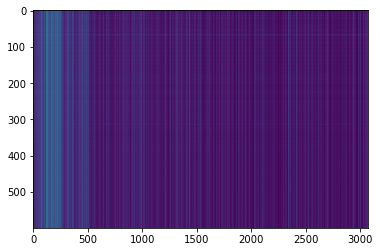

AUC      pAUC
Source_0  0.513200  0.505789
Source_1  0.513100  0.564211
Source_2  0.475200  0.494211
Target_0  0.560200  0.520526
Target_1  0.600100  0.517368
Target_2  0.528400  0.504737
mean      0.531700  0.517807
h_mean    0.528828  0.516878

2021-05-22 00:48:43,406 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2199.844462, val_AUC_hmean:0.528828, val_pAUC_hmean:0.516878, best_flag:True
2021-05-22 00:48:43,407 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.50it/s]
2021-05-22 00:48:43,790 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.82it/s]
2021-05-22 00:48:43,944 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.84it/s]


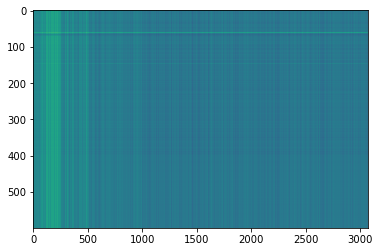

AUC      pAUC
Source_0  0.570300  0.494211
Source_1  0.653800  0.564737
Source_2  0.636100  0.553684
Target_0  0.641500  0.529474
Target_1  0.584800  0.534211
Target_2  0.468300  0.502105
mean      0.592467  0.529737
h_mean    0.584836  0.528520

2021-05-22 00:48:44,838 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1528.385600, val_AUC_hmean:0.584836, val_pAUC_hmean:0.528520, best_flag:True
2021-05-22 00:48:44,840 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.43it/s]
2021-05-22 00:48:45,237 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.90it/s]
2021-05-22 00:48:45,390 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.80it/s]
2021-05-22 00:48:45,558 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1300.151174, val_AUC_hmean:0.416647, val_pAUC_hmean:0.490346, best_flag:False
2021-05-22 00:48:45,559 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.84it/s]
2021-05-22 00:48:45,938 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.73it/s]
2021-05-22 00:48:46,094 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:48:

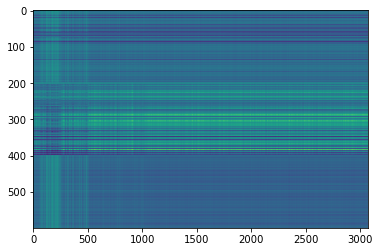

AUC      pAUC
Source_0  0.369700  0.494211
Source_1  0.746200  0.560000
Source_2  0.724300  0.652105
Target_0  0.428900  0.541053
Target_1  0.480400  0.482105
Target_2  0.533600  0.503158
mean      0.547183  0.538772
h_mean    0.512257  0.533211

2021-05-22 00:48:49,111 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1043.065221, val_AUC_hmean:0.512257, val_pAUC_hmean:0.533211, best_flag:True
2021-05-22 00:48:49,112 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.49it/s]
2021-05-22 00:48:49,495 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.38it/s]
2021-05-22 00:48:49,666 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]


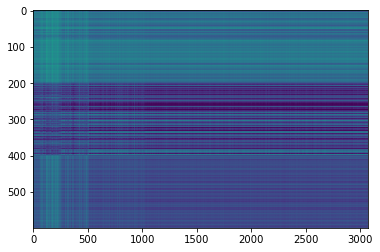

AUC      pAUC
Source_0  0.613900  0.583684
Source_1  0.469800  0.515263
Source_2  0.658400  0.635789
Target_0  0.461500  0.526316
Target_1  0.391600  0.498947
Target_2  0.530000  0.518947
mean      0.520867  0.546491
h_mean    0.504898  0.542591

2021-05-22 00:48:50,580 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:995.723694, val_AUC_hmean:0.504898, val_pAUC_hmean:0.542591, best_flag:True
2021-05-22 00:48:50,581 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.28it/s]
2021-05-22 00:48:50,993 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
2021-05-22 00:48:51,148 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.95it/s]
2021-05-22 00:48:51,304 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:966.449844, val_AUC_hmean:0.458799, val_pAUC_hmean:0.522057, best_flag:False
2021-05-22 00:48:51,305 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.67it/s]
2021-05-22 00:48:51,712 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:48:51,867 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:48:52

100%|██████████| 2/2 [00:00<00:00, 14.60it/s]
2021-05-22 00:49:02,535 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
2021-05-22 00:49:02,691 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:680.120132, val_AUC_hmean:0.390318, val_pAUC_hmean:0.505287, best_flag:False
2021-05-22 00:49:02,692 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.71it/s]
2021-05-22 00:49:03,073 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:49:03,227 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.49it/s]
2021-05-22 00:49:03,386 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:663.535166, val_AUC_hmean:0.409354, val_pAUC_hmean:0.497180, best_flag:False
2021-05-22 00:49:03,388 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.10it/s]
2021-05-22 00:49:03,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.30it/s]
2021-05-22 00:49:14,328 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:49:14,486 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.75it/s]
2021-05-22 00:49:14,644 - pytorch_modeler.py - INFO - epoch:42/300, train_losses:486.227079, val_AUC_hmean:0.461766, val_pAUC_hmean:0.524832, best_flag:False
2021-05-22 00:49:14,646 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.96it/s]
2021-05-22 00:49:15,024 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2021-05-22 00:49:15,179 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.98it/s]
2021-05-22 00:49:15,344 - pytorch_modeler.py - INFO - epoch:43/300, train_losses:476.484034, val_AUC_hmean:0.472761, val_pAUC_hmean:0.520518, best_flag:False
2021-05-22 00:49:15,346 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:49:25,953 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.99it/s]
2021-05-22 00:49:26,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:49:26,497 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:49:26,654 - pytorch_modeler.py - INFO - epoch:59/300, train_losses:355.922117, val_AUC_hmean:0.517397, val_pAUC_hmean:0.523537, best_flag:False
2021-05-22 00:49:26,655 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.60it/s]
2021-05-22 00:49:27,037 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:49:27,194 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:49:27,353 - pytorch_modeler.py - INFO - epoch:60/300, train_losses:348.821854, val_AUC_hmean:0.482283, val_pAUC_hmean:0.515626, best_flag:False
2021-05-22 00:49

100%|██████████| 2/2 [00:00<00:00, 14.20it/s]
2021-05-22 00:49:37,910 - pytorch_modeler.py - INFO - epoch:75/300, train_losses:270.421160, val_AUC_hmean:0.434238, val_pAUC_hmean:0.512327, best_flag:False
2021-05-22 00:49:37,911 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.57it/s]
2021-05-22 00:49:38,293 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.10it/s]
2021-05-22 00:49:38,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
2021-05-22 00:49:38,610 - pytorch_modeler.py - INFO - epoch:76/300, train_losses:265.449717, val_AUC_hmean:0.490374, val_pAUC_hmean:0.515614, best_flag:False
2021-05-22 00:49:38,611 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.74it/s]
2021-05-22 00:49:38,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2021-05-22 00:49:39,147 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
2021-05-22 00:49:49,715 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:49:49,873 - pytorch_modeler.py - INFO - epoch:92/300, train_losses:190.490852, val_AUC_hmean:0.482166, val_pAUC_hmean:0.512066, best_flag:False
2021-05-22 00:49:49,875 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.48it/s]
2021-05-22 00:49:50,258 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
2021-05-22 00:49:50,414 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
2021-05-22 00:49:50,571 - pytorch_modeler.py - INFO - epoch:93/300, train_losses:187.084990, val_AUC_hmean:0.497441, val_pAUC_hmean:0.514776, best_flag:False
2021-05-22 00:49:50,572 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.76it/s]
2021-05-22 00:49:50,952 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

2021-05-22 00:50:01,101 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.12it/s]
2021-05-22 00:50:01,489 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:50:01,646 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.86it/s]
2021-05-22 00:50:01,801 - pytorch_modeler.py - INFO - epoch:109/300, train_losses:137.597321, val_AUC_hmean:0.485003, val_pAUC_hmean:0.512129, best_flag:False
2021-05-22 00:50:01,803 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.29it/s]
2021-05-22 00:50:02,188 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
2021-05-22 00:50:02,345 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
2021-05-22 00:50:02,505 - pytorch_modeler.py - INFO - epoch:110/300, train_losses:134.786185, val_AUC_hmean:0.490519, val_pAUC_hmean:0.513825, best_flag:False
2021-05-22 00:

100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
2021-05-22 00:50:13,086 - pytorch_modeler.py - INFO - epoch:125/300, train_losses:116.785501, val_AUC_hmean:0.518308, val_pAUC_hmean:0.513730, best_flag:False
2021-05-22 00:50:13,087 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.80it/s]
2021-05-22 00:50:13,479 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
2021-05-22 00:50:13,635 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.45it/s]
2021-05-22 00:50:13,804 - pytorch_modeler.py - INFO - epoch:126/300, train_losses:104.225885, val_AUC_hmean:0.492379, val_pAUC_hmean:0.511980, best_flag:False
2021-05-22 00:50:13,805 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.99it/s]
2021-05-22 00:50:14,183 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:50:14,341 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:50:24,925 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:50:25,087 - pytorch_modeler.py - INFO - epoch:142/300, train_losses:75.884610, val_AUC_hmean:0.435316, val_pAUC_hmean:0.504823, best_flag:False
2021-05-22 00:50:25,088 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.19it/s]
2021-05-22 00:50:25,487 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
2021-05-22 00:50:25,643 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:50:25,803 - pytorch_modeler.py - INFO - epoch:143/300, train_losses:74.267971, val_AUC_hmean:0.475538, val_pAUC_hmean:0.512439, best_flag:False
2021-05-22 00:50:25,804 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.64it/s]
2021-05-22 00:50:26,186 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.10it/s]
2021-05-22 00:50:36,780 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
2021-05-22 00:50:36,938 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:50:37,099 - pytorch_modeler.py - INFO - epoch:159/300, train_losses:54.144962, val_AUC_hmean:0.430348, val_pAUC_hmean:0.507397, best_flag:False
2021-05-22 00:50:37,100 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.71it/s]
2021-05-22 00:50:37,481 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:50:37,636 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.78it/s]
2021-05-22 00:50:37,794 - pytorch_modeler.py - INFO - epoch:160/300, train_losses:53.004323, val_AUC_hmean:0.484627, val_pAUC_hmean:0.512438, best_flag:False
2021-05-22 00:50:37,796 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:50:48,360 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.56it/s]
2021-05-22 00:50:48,755 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
2021-05-22 00:50:48,922 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.78it/s]
2021-05-22 00:50:49,089 - pytorch_modeler.py - INFO - epoch:176/300, train_losses:38.343484, val_AUC_hmean:0.473318, val_pAUC_hmean:0.512991, best_flag:False
2021-05-22 00:50:49,090 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.91it/s]
2021-05-22 00:50:49,469 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:50:49,625 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.77it/s]
2021-05-22 00:50:49,792 - pytorch_modeler.py - INFO - epoch:177/300, train_losses:37.491430, val_AUC_hmean:0.479626, val_pAUC_hmean:0.510460, best_flag:False
2021-05-22 00:50

100%|██████████| 2/2 [00:00<00:00, 13.97it/s]
2021-05-22 00:51:00,463 - pytorch_modeler.py - INFO - epoch:192/300, train_losses:29.361434, val_AUC_hmean:0.492510, val_pAUC_hmean:0.512687, best_flag:False
2021-05-22 00:51:00,465 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.85it/s]
2021-05-22 00:51:00,856 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.78it/s]
2021-05-22 00:51:01,010 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.88it/s]
2021-05-22 00:51:01,167 - pytorch_modeler.py - INFO - epoch:193/300, train_losses:28.295532, val_AUC_hmean:0.480855, val_pAUC_hmean:0.512720, best_flag:False
2021-05-22 00:51:01,168 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.61it/s]
2021-05-22 00:51:01,550 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:51:01,709 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:51:12,272 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:51:12,432 - pytorch_modeler.py - INFO - epoch:209/300, train_losses:20.153847, val_AUC_hmean:0.470177, val_pAUC_hmean:0.511381, best_flag:False
2021-05-22 00:51:12,433 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.18it/s]
2021-05-22 00:51:12,820 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
2021-05-22 00:51:12,976 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
2021-05-22 00:51:13,136 - pytorch_modeler.py - INFO - epoch:210/300, train_losses:19.768797, val_AUC_hmean:0.479793, val_pAUC_hmean:0.511572, best_flag:False
2021-05-22 00:51:13,137 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.82it/s]
2021-05-22 00:51:13,529 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.32it/s]
2021-05-22 00:51:24,223 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.52it/s]
2021-05-22 00:51:24,401 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:51:24,566 - pytorch_modeler.py - INFO - epoch:226/300, train_losses:14.642393, val_AUC_hmean:0.489623, val_pAUC_hmean:0.514053, best_flag:False
2021-05-22 00:51:24,567 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.14it/s]
2021-05-22 00:51:24,954 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.52it/s]
2021-05-22 00:51:25,133 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.50it/s]
2021-05-22 00:51:25,301 - pytorch_modeler.py - INFO - epoch:227/300, train_losses:14.810460, val_AUC_hmean:0.489826, val_pAUC_hmean:0.513904, best_flag:False
2021-05-22 00:51:25,302 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:51:35,877 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.32it/s]
2021-05-22 00:51:36,262 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
2021-05-22 00:51:36,420 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:51:36,576 - pytorch_modeler.py - INFO - epoch:243/300, train_losses:10.231843, val_AUC_hmean:0.483898, val_pAUC_hmean:0.511751, best_flag:False
2021-05-22 00:51:36,577 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.82it/s]
2021-05-22 00:51:36,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.38it/s]
2021-05-22 00:51:37,137 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
2021-05-22 00:51:37,294 - pytorch_modeler.py - INFO - epoch:244/300, train_losses:10.490280, val_AUC_hmean:0.487131, val_pAUC_hmean:0.511709, best_flag:False
2021-05-22 00:51

2021-05-22 00:51:47,846 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.72it/s]
2021-05-22 00:51:48,238 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
2021-05-22 00:51:48,394 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
2021-05-22 00:51:48,553 - pytorch_modeler.py - INFO - epoch:260/300, train_losses:8.191151, val_AUC_hmean:0.481860, val_pAUC_hmean:0.511120, best_flag:False
2021-05-22 00:51:48,554 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.58it/s]
2021-05-22 00:51:48,936 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
2021-05-22 00:51:49,091 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
2021-05-22 00:51:49,249 - pytorch_modeler.py - INFO - epoch:261/300, train_losses:7.209236, val_AUC_hmean:0.491922, val_pAUC_hmean:0.513123, best_flag:False
2021-05-22 00:51:4

100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:51:59,855 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:7.792100, val_AUC_hmean:0.473160, val_pAUC_hmean:0.508843, best_flag:False
2021-05-22 00:51:59,856 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.87it/s]
2021-05-22 00:52:00,247 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
2021-05-22 00:52:00,404 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.73it/s]
2021-05-22 00:52:00,572 - pytorch_modeler.py - INFO - epoch:277/300, train_losses:6.780122, val_AUC_hmean:0.480446, val_pAUC_hmean:0.511699, best_flag:False
2021-05-22 00:52:00,573 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 32.24it/s]
2021-05-22 00:52:00,948 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2021-05-22 00:52:01,102 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2

100%|██████████| 2/2 [00:00<00:00, 13.50it/s]
2021-05-22 00:52:11,682 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:52:11,840 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:5.036693, val_AUC_hmean:0.490309, val_pAUC_hmean:0.514005, best_flag:False
2021-05-22 00:52:11,841 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.87it/s]
2021-05-22 00:52:12,220 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.15it/s]
2021-05-22 00:52:12,381 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.72it/s]
2021-05-22 00:52:12,550 - pytorch_modeler.py - INFO - epoch:294/300, train_losses:4.171446, val_AUC_hmean:0.488061, val_pAUC_hmean:0.513888, best_flag:False
2021-05-22 00:52:12,551 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.98it/s]
2021-05-22 00:52:12,929 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

AUC      pAUC
Source_0  0.613900  0.583684
Source_1  0.469800  0.515263
Source_2  0.658400  0.635789
Target_0  0.461500  0.526316
Target_1  0.391600  0.498947
Target_2  0.530000  0.518947
mean      0.520867  0.546491
h_mean    0.504898  0.542591

2021-05-22 00:52:16,778 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-05-22 00:52:16,778 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 215.507319212 [sec]


2021-05-22 00:52:17,298 - 00_train.py - INFO - TRAINING
2021-05-22 00:52:17,492 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 31.54it/s]
2021-05-22 00:52:17,874 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
2021-05-22 00:52:18,032 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.06it/s]


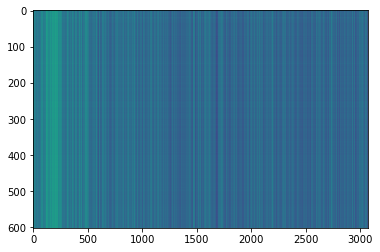

AUC      pAUC
Source_0  0.469500  0.491053
Source_1  0.446400  0.538947
Source_2  0.292602  0.481190
Target_0  0.529000  0.504211
Target_1  0.485918  0.527712
Target_2  0.550365  0.525992
mean      0.462298  0.511517
h_mean    0.442707  0.510659

2021-05-22 00:52:18,959 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1985.974833, val_AUC_hmean:0.442707, val_pAUC_hmean:0.510659, best_flag:True
2021-05-22 00:52:18,960 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.65it/s]
2021-05-22 00:52:19,341 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:52:19,499 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]


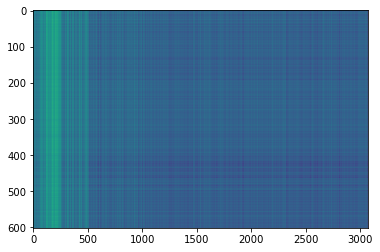

AUC      pAUC
Source_0  0.509500  0.537895
Source_1  0.549500  0.531579
Source_2  0.501426  0.555305
Target_0  0.579900  0.506842
Target_1  0.571939  0.507841
Target_2  0.400807  0.507275
mean      0.518845  0.524456
h_mean    0.510869  0.523810

2021-05-22 00:52:20,430 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1361.775675, val_AUC_hmean:0.510869, val_pAUC_hmean:0.523810, best_flag:True
2021-05-22 00:52:20,431 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.56it/s]
2021-05-22 00:52:20,814 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:52:20,974 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
2021-05-22 00:52:21,132 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1211.181264, val_AUC_hmean:0.402634, val_pAUC_hmean:0.511842, best_flag:False
2021-05-22 00:52:21,133 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.73it/s]
2021-05-22 00:52:21,526 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.93it/s]
2021-05-22 00:52:21,689 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
2021-05-22 00:52:

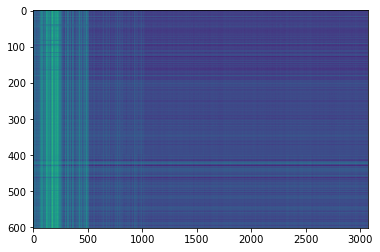

AUC      pAUC
Source_0  0.412700  0.510526
Source_1  0.503500  0.578947
Source_2  0.431283  0.555774
Target_0  0.461100  0.505263
Target_1  0.345000  0.486574
Target_2  0.524414  0.531860
mean      0.446333  0.528158
h_mean    0.437892  0.526322

2021-05-22 00:52:24,033 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1024.918406, val_AUC_hmean:0.437892, val_pAUC_hmean:0.526322, best_flag:True
2021-05-22 00:52:24,034 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.53it/s]
2021-05-22 00:52:24,417 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
2021-05-22 00:52:24,573 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.05it/s]
2021-05-22 00:52:24,739 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:991.297913, val_AUC_hmean:0.395754, val_pAUC_hmean:0.517222, best_flag:False
2021-05-22 00:52:24,741 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.51it/s]
2021-05-22 00:52:25,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
2021-05-22 00:52:25,295 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.08it/s]
2021-05-22 00:52:2

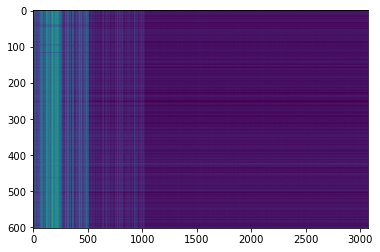

AUC      pAUC
Source_0  0.552500  0.503684
Source_1  0.333200  0.502105
Source_2  0.614171  0.599400
Target_0  0.560300  0.506316
Target_1  0.444388  0.501933
Target_2  0.593137  0.579716
mean      0.516283  0.532192
h_mean    0.493406  0.529210

2021-05-22 00:52:29,061 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:870.019608, val_AUC_hmean:0.493406, val_pAUC_hmean:0.529210, best_flag:True
2021-05-22 00:52:29,062 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.08it/s]
2021-05-22 00:52:29,463 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
2021-05-22 00:52:29,627 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.53it/s]


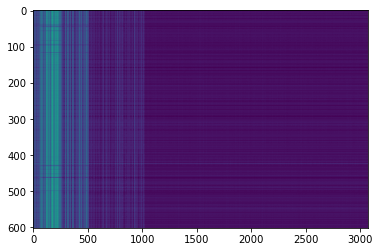

AUC      pAUC
Source_0  0.461700  0.501053
Source_1  0.589900  0.553684
Source_2  0.554991  0.580636
Target_0  0.588600  0.520000
Target_1  0.469184  0.494952
Target_2  0.627355  0.588316
mean      0.548622  0.539773
h_mean    0.541162  0.537279

2021-05-22 00:52:30,553 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:854.394023, val_AUC_hmean:0.541162, val_pAUC_hmean:0.537279, best_flag:True
2021-05-22 00:52:30,554 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.07it/s]
2021-05-22 00:52:30,942 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
2021-05-22 00:52:31,101 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.79it/s]
2021-05-22 00:52:31,258 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:833.315954, val_AUC_hmean:0.565617, val_pAUC_hmean:0.530511, best_flag:False
2021-05-22 00:52:31,259 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.25it/s]
2021-05-22 00:52:31,658 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
2021-05-22 00:52:31,816 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:52:

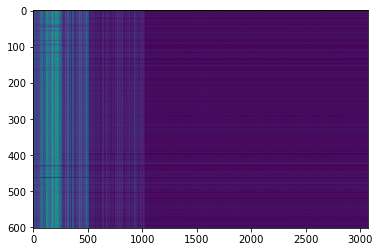

AUC      pAUC
Source_0  0.628800  0.524211
Source_1  0.637000  0.531579
Source_2  0.609715  0.573131
Target_0  0.581100  0.523158
Target_1  0.542245  0.518475
Target_2  0.632449  0.589429
mean      0.605218  0.543330
h_mean    0.603226  0.541987

2021-05-22 00:52:33,451 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:802.189743, val_AUC_hmean:0.603226, val_pAUC_hmean:0.541987, best_flag:True
2021-05-22 00:52:33,452 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.56it/s]
2021-05-22 00:52:33,834 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
2021-05-22 00:52:33,991 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.97it/s]
2021-05-22 00:52:34,147 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:784.051478, val_AUC_hmean:0.527281, val_pAUC_hmean:0.540242, best_flag:False
2021-05-22 00:52:34,148 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.43it/s]
2021-05-22 00:52:34,532 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
2021-05-22 00:52:34,694 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.44it/s]
2021-05-22 00:52:

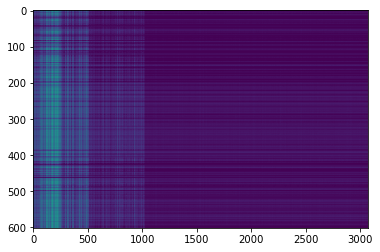

AUC      pAUC
Source_0  0.686200  0.580526
Source_1  0.520200  0.588421
Source_2  0.659091  0.629890
Target_0  0.590300  0.528421
Target_1  0.461531  0.511923
Target_2  0.657824  0.620085
mean      0.595858  0.576544
h_mean    0.583782  0.573167

2021-05-22 00:52:39,928 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:681.469533, val_AUC_hmean:0.583782, val_pAUC_hmean:0.573167, best_flag:True
2021-05-22 00:52:39,929 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.08it/s]
2021-05-22 00:52:40,318 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.48it/s]
2021-05-22 00:52:40,497 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.55it/s]
2021-05-22 00:52:40,657 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:672.244848, val_AUC_hmean:0.445097, val_pAUC_hmean:0.541353, best_flag:False
2021-05-22 00:52:40,658 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.28it/s]
2021-05-22 00:52:41,044 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.51it/s]
2021-05-22 00:52:41,212 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.39it/s]
2021-05-22 00:52:

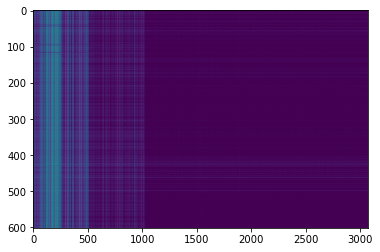

AUC      pAUC
Source_0  0.491000  0.513684
Source_1  0.757700  0.653158
Source_2  0.752763  0.647716
Target_0  0.574200  0.534737
Target_1  0.574796  0.537916
Target_2  0.632930  0.584067
mean      0.630565  0.578546
h_mean    0.615628  0.573456

2021-05-22 00:52:49,252 - pytorch_modeler.py - INFO - epoch:36/300, train_losses:538.323115, val_AUC_hmean:0.615628, val_pAUC_hmean:0.573456, best_flag:True
2021-05-22 00:52:49,252 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.26it/s]
2021-05-22 00:52:49,639 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
2021-05-22 00:52:49,799 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.03it/s]
2021-05-22 00:52:49,964 - pytorch_modeler.py - INFO - epoch:37/300, train_losses:530.607432, val_AUC_hmean:0.615383, val_pAUC_hmean:0.556780, best_flag:False
2021-05-22 00:52:49,965 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.01it/s]
2021-05-22 00:52:50,354 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.39it/s]
2021-05-22 00:52:50,512 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.10it/s]
2021-05-22 00:52:

100%|██████████| 2/2 [00:00<00:00, 12.98it/s]
2021-05-22 00:53:01,231 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
2021-05-22 00:53:01,394 - pytorch_modeler.py - INFO - epoch:53/300, train_losses:393.969798, val_AUC_hmean:0.591855, val_pAUC_hmean:0.531101, best_flag:False
2021-05-22 00:53:01,396 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.53it/s]
2021-05-22 00:53:01,778 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:53:01,937 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:53:02,097 - pytorch_modeler.py - INFO - epoch:54/300, train_losses:386.034091, val_AUC_hmean:0.584675, val_pAUC_hmean:0.537118, best_flag:False
2021-05-22 00:53:02,098 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.06it/s]
2021-05-22 00:53:02,487 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.98it/s]
2021-05-22 00:53:13,154 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
2021-05-22 00:53:13,316 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:53:13,478 - pytorch_modeler.py - INFO - epoch:70/300, train_losses:288.213359, val_AUC_hmean:0.455333, val_pAUC_hmean:0.521302, best_flag:False
2021-05-22 00:53:13,480 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.74it/s]
2021-05-22 00:53:13,872 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.30it/s]
2021-05-22 00:53:14,032 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.38it/s]
2021-05-22 00:53:14,204 - pytorch_modeler.py - INFO - epoch:71/300, train_losses:282.252378, val_AUC_hmean:0.605716, val_pAUC_hmean:0.552050, best_flag:False
2021-05-22 00:53:14,205 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:53:24,939 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.33it/s]
2021-05-22 00:53:25,337 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
2021-05-22 00:53:25,494 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
2021-05-22 00:53:25,655 - pytorch_modeler.py - INFO - epoch:87/300, train_losses:211.794038, val_AUC_hmean:0.586646, val_pAUC_hmean:0.539932, best_flag:False
2021-05-22 00:53:25,656 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.65it/s]
2021-05-22 00:53:26,038 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
2021-05-22 00:53:26,196 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:53:26,360 - pytorch_modeler.py - INFO - epoch:88/300, train_losses:207.577290, val_AUC_hmean:0.597663, val_pAUC_hmean:0.552404, best_flag:False
2021-05-22 00:53

100%|██████████| 2/2 [00:00<00:00, 14.08it/s]
2021-05-22 00:53:37,001 - pytorch_modeler.py - INFO - epoch:103/300, train_losses:157.963264, val_AUC_hmean:0.595570, val_pAUC_hmean:0.546399, best_flag:False
2021-05-22 00:53:37,002 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.57it/s]
2021-05-22 00:53:37,384 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
2021-05-22 00:53:37,542 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
2021-05-22 00:53:37,702 - pytorch_modeler.py - INFO - epoch:104/300, train_losses:154.653113, val_AUC_hmean:0.595411, val_pAUC_hmean:0.543922, best_flag:False
2021-05-22 00:53:37,703 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.99it/s]
2021-05-22 00:53:38,093 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
2021-05-22 00:53:38,251 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 12/12 [00:00<00:00, 31.39it/s]
2021-05-22 00:53:48,812 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.01it/s]
2021-05-22 00:53:48,976 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
2021-05-22 00:53:49,137 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:115.829552, val_AUC_hmean:0.539798, val_pAUC_hmean:0.536282, best_flag:False
2021-05-22 00:53:49,138 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.09it/s]
2021-05-22 00:53:49,526 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.35it/s]
2021-05-22 00:53:49,685 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
2021-05-22 00:53:49,848 - pytorch_modeler.py - INFO - epoch:121/300, train_losses:113.432470, val_AUC_hmean:0.590707, val_pAUC_hmean:0.541310, best_flag:False
2021-05-22 00:53:49,850 - pytorch_modeler.py - INFO - train
100%|█████████

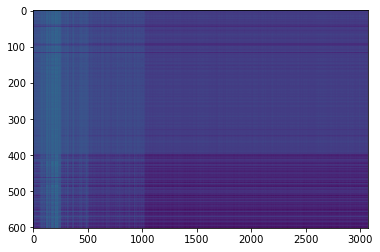

AUC      pAUC
Source_0  0.459000  0.570000
Source_1  0.753300  0.756842
Source_2  0.787344  0.809082
Target_0  0.397900  0.485789
Target_1  0.590306  0.521590
Target_2  0.589485  0.491289
mean      0.596222  0.605765
h_mean    0.561805  0.581237

2021-05-22 00:53:57,782 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:94.398040, val_AUC_hmean:0.561805, val_pAUC_hmean:0.581237, best_flag:True
2021-05-22 00:53:57,783 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.13it/s]
2021-05-22 00:53:58,171 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
2021-05-22 00:53:58,335 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.89it/s]
2021-05-22 00:53:58,501 - pytorch_modeler.py - INFO - epoch:132/300, train_losses:92.431314, val_AUC_hmean:0.532094, val_pAUC_hmean:0.551425, best_flag:False
2021-05-22 00:53:58,502 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.07it/s]
2021-05-22 00:53:58,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.77it/s]
2021-05-22 00:53:59,055 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
2021-05-22 00:53:

100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:54:09,811 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
2021-05-22 00:54:09,979 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:71.988603, val_AUC_hmean:0.577535, val_pAUC_hmean:0.515459, best_flag:False
2021-05-22 00:54:09,980 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.59it/s]
2021-05-22 00:54:10,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
2021-05-22 00:54:10,535 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.67it/s]
2021-05-22 00:54:10,714 - pytorch_modeler.py - INFO - epoch:149/300, train_losses:71.040569, val_AUC_hmean:0.577710, val_pAUC_hmean:0.506579, best_flag:False
2021-05-22 00:54:10,716 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.74it/s]
2021-05-22 00:54:11,108 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.76it/s]
2021-05-22 00:54:21,817 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.08it/s]
2021-05-22 00:54:21,980 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
2021-05-22 00:54:22,143 - pytorch_modeler.py - INFO - epoch:165/300, train_losses:50.863960, val_AUC_hmean:0.574057, val_pAUC_hmean:0.506633, best_flag:False
2021-05-22 00:54:22,144 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.35it/s]
2021-05-22 00:54:22,542 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
2021-05-22 00:54:22,700 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.30it/s]
2021-05-22 00:54:22,862 - pytorch_modeler.py - INFO - epoch:166/300, train_losses:50.058146, val_AUC_hmean:0.572589, val_pAUC_hmean:0.506094, best_flag:False
2021-05-22 00:54:22,863 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:54:33,622 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.41it/s]
2021-05-22 00:54:34,006 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
2021-05-22 00:54:34,170 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:54:34,334 - pytorch_modeler.py - INFO - epoch:182/300, train_losses:36.204650, val_AUC_hmean:0.575050, val_pAUC_hmean:0.507131, best_flag:False
2021-05-22 00:54:34,336 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.55it/s]
2021-05-22 00:54:34,719 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:54:34,880 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
2021-05-22 00:54:35,042 - pytorch_modeler.py - INFO - epoch:183/300, train_losses:35.758901, val_AUC_hmean:0.571966, val_pAUC_hmean:0.504728, best_flag:False
2021-05-22 00:54

100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
2021-05-22 00:54:45,818 - pytorch_modeler.py - INFO - epoch:198/300, train_losses:26.958428, val_AUC_hmean:0.576416, val_pAUC_hmean:0.506770, best_flag:False
2021-05-22 00:54:45,819 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.10it/s]
2021-05-22 00:54:46,207 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.25it/s]
2021-05-22 00:54:46,369 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.35it/s]
2021-05-22 00:54:46,530 - pytorch_modeler.py - INFO - epoch:199/300, train_losses:26.420717, val_AUC_hmean:0.573617, val_pAUC_hmean:0.507665, best_flag:False
2021-05-22 00:54:46,531 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.65it/s]
2021-05-22 00:54:46,913 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.95it/s]
2021-05-22 00:54:47,077 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
2021-05-22 00:54:57,896 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]
2021-05-22 00:54:58,058 - pytorch_modeler.py - INFO - epoch:215/300, train_losses:19.462348, val_AUC_hmean:0.573745, val_pAUC_hmean:0.504106, best_flag:False
2021-05-22 00:54:58,059 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.09it/s]
2021-05-22 00:54:58,475 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.45it/s]
2021-05-22 00:54:58,643 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.17it/s]
2021-05-22 00:54:58,819 - pytorch_modeler.py - INFO - epoch:216/300, train_losses:19.053344, val_AUC_hmean:0.570798, val_pAUC_hmean:0.504994, best_flag:False
2021-05-22 00:54:58,820 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.87it/s]
2021-05-22 00:54:59,225 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 31.36it/s]
2021-05-22 00:55:10,046 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.35it/s]
2021-05-22 00:55:10,216 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.26it/s]
2021-05-22 00:55:10,378 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:14.064996, val_AUC_hmean:0.572097, val_pAUC_hmean:0.504195, best_flag:False
2021-05-22 00:55:10,379 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.43it/s]
2021-05-22 00:55:10,776 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
2021-05-22 00:55:10,960 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.88it/s]
2021-05-22 00:55:11,127 - pytorch_modeler.py - INFO - epoch:233/300, train_losses:13.754850, val_AUC_hmean:0.569997, val_pAUC_hmean:0.503950, best_flag:False
2021-05-22 00:55:11,128 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-22 00:55:21,925 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.58it/s]
2021-05-22 00:55:22,307 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
2021-05-22 00:55:22,472 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.00it/s]
2021-05-22 00:55:22,637 - pytorch_modeler.py - INFO - epoch:249/300, train_losses:9.902219, val_AUC_hmean:0.572366, val_pAUC_hmean:0.505767, best_flag:False
2021-05-22 00:55:22,638 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.36it/s]
2021-05-22 00:55:23,023 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.11it/s]
2021-05-22 00:55:23,184 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.19it/s]
2021-05-22 00:55:23,350 - pytorch_modeler.py - INFO - epoch:250/300, train_losses:9.815603, val_AUC_hmean:0.571557, val_pAUC_hmean:0.505104, best_flag:False
2021-05-22 00:55:2

2021-05-22 00:55:34,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 31.09it/s]
2021-05-22 00:55:34,563 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
2021-05-22 00:55:34,723 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:55:34,883 - pytorch_modeler.py - INFO - epoch:266/300, train_losses:7.159081, val_AUC_hmean:0.570671, val_pAUC_hmean:0.505230, best_flag:False
2021-05-22 00:55:34,885 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.49it/s]
2021-05-22 00:55:35,281 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
2021-05-22 00:55:35,443 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
2021-05-22 00:55:35,604 - pytorch_modeler.py - INFO - epoch:267/300, train_losses:7.216380, val_AUC_hmean:0.573062, val_pAUC_hmean:0.505485, best_flag:False
2021-05-22 00:55:3

2021-05-22 00:55:46,383 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.20it/s]
2021-05-22 00:55:46,783 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]
2021-05-22 00:55:46,942 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
2021-05-22 00:55:47,102 - pytorch_modeler.py - INFO - epoch:283/300, train_losses:5.257424, val_AUC_hmean:0.571907, val_pAUC_hmean:0.504686, best_flag:False
2021-05-22 00:55:47,104 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.99it/s]
2021-05-22 00:55:47,493 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
2021-05-22 00:55:47,651 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 14.22it/s]
2021-05-22 00:55:47,813 - pytorch_modeler.py - INFO - epoch:284/300, train_losses:5.125150, val_AUC_hmean:0.571273, val_pAUC_hmean:0.504747, best_flag:False
2021-05-22 00:55:4

2021-05-22 00:55:58,568 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 30.86it/s]
2021-05-22 00:55:58,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.04it/s]
2021-05-22 00:55:59,131 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 13.55it/s]
2021-05-22 00:55:59,302 - pytorch_modeler.py - INFO - epoch:300/300, train_losses:3.660701, val_AUC_hmean:0.572298, val_pAUC_hmean:0.505770, best_flag:False
2021-05-22 00:55:59,303 - pytorch_modeler.py - INFO - best model, epoch:131/300, train_losses:94.398040, val_pAUC_hmean:0.581237,


AUC      pAUC
Source_0  0.459000  0.570000
Source_1  0.753300  0.756842
Source_2  0.787344  0.809082
Target_0  0.397900  0.485789
Target_1  0.590306  0.521590
Target_2  0.589485  0.491289
mean      0.596222  0.605765
h_mean    0.561805  0.581237

elapsed time: 222.529927969 [sec]


In [12]:
for machine_type in machine_types:
    run(machine_type)

In [13]:
#run(machine_types[0])